In [9]:
import os
import covid19 as c19
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpyro as npy
import numpyro.distributions as dist
from numpyro.infer.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from jax.nn import softplus
import jax.numpy as jnp
from jax import random
import seaborn as sns
import scipy.stats as stats
from jax.nn import sigmoid
from jax.ops import index_update, index
from covid19.utils import discretise_epistm

In [10]:
LAD = c19.get_geodata()
specimen = pd.read_csv('newest_data/specimen.csv', index_col=0)
deaths = pd.read_csv('newest_data/death.csv', index_col=0)
lineage = pd.read_csv('lineage_weeks_ltla.csv', index_col=0)
# prepare data
strain = (
    lineage
    .loc[:, ['WeekEndDate'] + [ i for i in lineage.columns.tolist() if i.endswith('Lineage') ]]
    .rename(columns=lambda x: x.rstrip('_Lineage') if x.endswith('_Lineage') else x)
    .set_index('WeekEndDate')).T
other = (
    lineage
    .loc[:, ['WeekEndDate'] + [ i for i in lineage.columns.tolist() if i.endswith('Other') ]]
    .rename(columns=lambda x: x.rstrip('_Other') if x.endswith('_Other') else x)
    .set_index('WeekEndDate')).T

# genrate arrays
specimen = (
    LAD
    .merge(specimen.iloc[:, -110:].reset_index(), left_on='lad19cd', right_on='index', how='left')
    .iloc[:, -110:-3].values)
deaths = (
    LAD
    .merge(deaths.iloc[:, -110:].reset_index(), left_on='lad19cd', right_on='index', how='left')
    .iloc[:, -110:].values)
strain = (
    LAD
    .merge(strain.reset_index(), left_on='lad19cd', right_on='index', how='left')
    .iloc[:, -11:].values)
other = (
    LAD
    .merge(other.reset_index(), left_on='lad19cd', right_on='index', how='left')
    .iloc[:, -11:]
    .values)
total = strain + other

In [11]:
specimen.shape

(382, 107)

In [12]:
S = np.where(~np.isnan(strain[:,1]))[0] # which locations do have strain data available
U = LAD.utla19id.values
C = LAD.ctry19id.values
N = LAD.pop18.values
_, B_forecast, Bdiff_forecast = c19.create_spline_basis(np.arange(124), num_knots = 8)

B = B_forecast[:107,:]
Bdiff = Bdiff_forecast[:107, :]

In [13]:
dates = pd.DataFrame({'date': [ str(d)[:10] for d in pd.date_range(start='2020-09-01', end='2021-01-02')], 'x': np.arange(124)})
strain_times = dates[dates.date.isin(lineage.WeekEndDate)]['x'].values
X = np.stack([np.ones_like(strain_times), strain_times]).T
X_specimen_forecast = np.stack([np.ones_like(dates.x.values), dates.x.values]).T
X_specimen = X_specimen_forecast[:107, :]

In [14]:
strain_times

array([26, 33, 40, 47, 54, 61, 68, 75, 82, 89, 96])

In [24]:
def plot(idx):
    d = pd.date_range(start='2020-09-01', periods=specimen.shape[1], freq='d').to_pydatetime().tolist()    
    d2 = pd.to_datetime(lineage['WeekEndDate']).tolist()
    d3 = pd.date_range(start='2020-11-01', end='2020-12-16').to_pydatetime().tolist()
    fig, ax = plt.subplots(3, 1, figsize=(6, 6))
    ax[0].plot(d, specimen[idx], '.')
    ax[0].plot(d, svi.mean('λ')[idx], label='total', color='C1')
    ax[0].fill_between(d, svi.lower('λ')[idx], svi.upper('λ')[idx], alpha=.2, color='C1')
    ax[0].set_ylabel('New cases', fontsize=16)
    if idx in S:
        ax[0].plot(d, svi.mean('λ_strain')[idx], label='strain', color='C3')
        ax[0].fill_between(d, svi.lower('λ_strain')[idx], svi.upper('λ_strain')[idx], alpha=.2, color='C3')
        ax[0].plot(d, svi.mean('λ_base')[idx], label='other', color='C2')
        ax[0].fill_between(d, svi.lower('λ_base')[idx], svi.upper('λ_base')[idx], alpha=.2, color='C2')
    ax[0].legend()
    ax[0].set_xticklabels([])
    ax[0].set_title(LAD.loc[idx, 'lad19nm'], fontsize=20)
    if idx in S:
        ax2 = ax[1].twinx()
        ax2.set_ylabel('Genomes', fontsize=16, color='C7')
        ax2.bar(d2, total[idx], label='total', width=2, color='C7', alpha=.5)
        ax2.legend(loc='upper left')
        ax2.set_xticklabels([])
        ax[1].plot(d2, svi.mean('p')[idx][strain_times], color='C3')
        ax[1].fill_between(d2, svi.lower('p')[idx][strain_times], svi.upper('p')[idx][strain_times], color='C3', alpha=.2)
        ax[1].plot(d2, strain[idx]/total[idx], 'o', color='C3', label='strain')
        ax[1].set_xlim(*ax[0].get_xlim())
        ax[1].set_ylim([0, 1])
        ax[1].set_ylabel('$\mathbb{P}$(strain)', fontsize=16)
        ax[1].set_zorder(ax2.get_zorder()+1)
        ax[1].patch.set_visible(False)
    #ax[2].plot(d, svi.mean('R')[idx], color='C1', )
    #ax[2].fill_between(d, svi.lower('R')[idx], svi.upper('R')[idx], alpha=.2, color='C1')
    if idx in S:
        ax[2].plot(d3, svi.mean('R_strain')[idx][61:], color='C3', )
        ax[2].fill_between(d3, svi.lower('R_strain')[idx][61:], svi.upper('R_strain')[idx][61:], alpha=.2, color='C3')
        ax[2].plot(d, svi.mean('R_base')[idx], color='C2', )
        ax[2].fill_between(d, svi.lower('R_base')[idx], svi.upper('R_base')[idx], alpha=.2, color='C2')
    ax[2].set_ylim([.5, 3])
    ax[2].axvspan(d[65], d[92], color='C7', alpha=.2, label='lockdown')
    ax[2].grid(True)    
    ax[2].set_ylabel(r'$R$', fontsize=16)
    ax[2].legend(loc='upper left')
    ax[2].axhline(1, linestyle='--', color='k')
    plt.gcf().autofmt_xdate()

In [16]:
class RelaxedStrainModel(object):
    """
    UTLA model

    Parameters:
    -----------
    B: spline basis vectors
    C: country indicator variables
    U: UTLA indicator variables
    N: Population
    y: incidences (locations x time)
    """
    
    def model(self, B, Bdiff, X, S, C, U, N, y, strain, total):
        mask_context = c19.missing_data_plate(y)
        
        num_strain_loc = S.shape[0]
        num_strain_time = X.shape[0]
        
        num_countries = len(np.unique(C))
        num_utla = len(np.unique(U)) - num_countries
        num_timesteps, num_basis = B.shape
        num_locations = N.shape[0]

        plate_time = npy.plate("time", num_timesteps, dim=-1)
        plate_locations = npy.plate("locations", num_locations, dim=-2)
        
        plate_strain_time = npy.plate("strain_time", num_strain_time, dim=-1)
        plate_strain_locations = npy.plate("strain_locations", num_strain_loc, dim=-2)
        
        # dispersion parameter for lads
        τ = npy.sample(
            "τ",
            dist.Normal(
                jnp.zeros(num_locations).reshape(-1, 1),
                10 * jnp.ones(num_locations).reshape(-1, 1),
            ),
        )
        
        μ_β = npy.sample(
            "μ_β",
            dist.Normal(
                jnp.zeros((num_countries, num_basis)),
                10 * jnp.ones((num_countries, num_basis)),
            ),
        )
        σ_β = npy.sample("σ_β", dist.HalfNormal(jnp.ones((num_countries, num_basis))))

        μ_utla = npy.sample(
            "μ_utla",
            dist.Normal(
                μ_β[0],
                10 * jnp.ones((num_utla, num_basis)),
            ),
        )
        μ = jnp.concatenate([μ_β, μ_utla])
        
        # beta base for all of the 382 local authorities
        # draws from the UTLA/Country priors (indexed with U and C)
        β_base = npy.sample(
            "β_base",
            dist.MultivariateNormal(
                μ[U],
                σ_β[C].reshape(num_locations, num_basis, 1)
                * jnp.eye(num_basis).reshape(1, num_basis, num_basis),
            ),
        )
        
        # draw scaling factor a, S indexes the locations for which strain information is 
        # available, dim(β_new) = 194 x num_basis
        #a = jnp.array([1.])#n
        a = jnp.exp(npy.sample('a', dist.Normal(jnp.zeros(num_strain_loc), jnp.ones(num_strain_loc))) * 0.05)
        b = npy.sample('b', dist.Normal(jnp.ones(num_strain_loc), jnp.ones(num_strain_loc))) * 0.05
        c = npy.sample('c', dist.Normal(jnp.zeros(num_strain_loc), jnp.ones(num_strain_loc))) - 5
        
        β_new = a.reshape(-1, 1) * β_base[S]
        # β strain has the full dimension 384 x num_basis, zeros at the locations where strain
        # information is not available and elsewhere β_new
        β_strain = jnp.zeros((num_locations, num_basis))
        β_strain = npy.deterministic('β_strain', index_update(β_strain, index[S, :], β_new))        
        
        b_strain = jnp.zeros((num_locations))
        b_strain = npy.deterministic('b_strain', index_update(b_strain, S, b))        
        

        μ_new = npy.deterministic(
             'μ_new', 
                    jnp.exp(jnp.inner(β_new, B) + b.reshape(-1, 1) * (jnp.arange(num_timesteps).reshape(1,-1)) + c.reshape(-1,1) )
        )
                #print(μ_new)
                #print(b.reshape(-1, 1) * (jnp.arange(num_timesteps).reshape(1,-1)))
                
        μ_base = npy.deterministic('μ_base', jnp.exp(jnp.inner(β_base, B)))
                #μ_strain contains at locations for which strain information is available
                # μ_new, else 0
        μ_strain = jnp.zeros((num_locations, num_timesteps))
        μ_strain = npy.deterministic('μ_strain', index_update(μ_strain, index[S, :], μ_new))
            
        μ = npy.deterministic(
                    "μ",
                    μ_strain + μ_base,
                )

        
        λ_strain = npy.deterministic('λ_strain', N.reshape(-1,1) * μ_strain)
        λ_base = npy.deterministic('λ_base', N.reshape(-1,1) * μ_base)        
        λ = npy.deterministic('λ', N.reshape(-1,1) * μ)
                
        R_strain = npy.deterministic('R_strain', jnp.exp((jnp.inner(β_strain, Bdiff) + b_strain.reshape(-1, 1)) * 6.5))
        R_base = npy.deterministic('R_base', jnp.exp(jnp.inner(β_base, Bdiff) * 6.5))
        R = npy.deterministic('R', jnp.log(R_strain/R_base))

        
        with plate_locations:
            with plate_time:                
                with mask_context:
                    npy.sample(
                        "y", c19.NegativeBinomial(λ, jnp.exp(τ)), obs=np.nan_to_num(y)
                    )
        #print(μ_strain.shape)
        
        p = npy.deterministic('p', μ_strain/μ)
        
        with plate_strain_locations:
            with plate_strain_time:
                #p = npy.deterministic('p', 1 / (1 + jnp.exp(jnp.inner(β_base-β_strain , B[X,:]) -  b.reshape(-1, 1) * (jnp.arange(num_timesteps)[X].reshape(1,-1)) + c.reshape(-1,1))))
                #p = npy.deterministic('p', (μ_strain/μ)[:,X])
                #print(p.shape)
                npy.sample('strain', dist.Binomial(probs=p[:,X][S,:], total_count=total), obs=strain)

    def guide(self, B, Bdiff, X, S, C, U, N, y, strain, total):
        
        num_strain_loc = S.shape[0]
        num_strain_time = X.shape[0]
        
        num_countries = len(np.unique(C))
        num_timesteps, num_basis = B.shape
        num_locations = N.shape[0]

        num_utla = len(np.unique(U)) - num_countries

        plate_time = npy.plate("time", num_timesteps, dim=-1)
        plate_locations = npy.plate("locations", num_locations, dim=-2)

        # spatial pooling
        μ_β_loc = npy.param("μ_β_loc", jnp.zeros((num_countries, num_basis)))
        μ_σ_scale = npy.param(
            "μ_σ_scale",
            jnp.ones((num_countries, num_basis)),
            constraint=dist.constraints.positive,
        )
        σ_β_scale = npy.param(
            "σ_β_scale",
            jnp.ones((num_countries, num_basis)),
            constraint=dist.constraints.positive,
        )

        μ_β = npy.sample("μ_β", dist.Normal(μ_β_loc, μ_σ_scale))
        σ_β = npy.sample("σ_β", dist.HalfNormal(σ_β_scale))

        μ_utla_loc = npy.param("μ_utla_loc", jnp.zeros((num_utla, num_basis)))
        μ_utla_scale = npy.param(
            "μ_utla_scale",
            jnp.ones((num_utla, num_basis)),
            constraint=dist.constraints.positive,
        )

        μ_utla = npy.sample(
            "μ_utla",
            dist.Normal(
                μ_utla_loc,
                μ_utla_scale,
            ),
        )

        # mean / sd for parameter s
        β_loc = npy.param("β_loc", jnp.zeros((num_locations, num_basis)))
        β_scale = npy.param(
            "β_scale",
            jnp.stack(num_locations * [jnp.eye(num_basis)]),
            constraint=dist.constraints.lower_cholesky,
        )

        # cov = jnp.matmul(β_σ, jnp.transpose(β_σ, (0, 2, 1)))
        β_base = npy.sample("β_base", dist.MultivariateNormal(β_loc, scale_tril=β_scale))  # cov
        
        a_loc = npy.param('a_loc', jnp.zeros(num_strain_loc))
        a_scale = npy.param('a_scale', jnp.ones(num_strain_loc), constraint=dist.constraints.positive)
        b_loc = npy.param('b_loc', jnp.zeros(num_strain_loc))
        b_scale = npy.param('b_scale', jnp.ones(num_strain_loc), constraint=dist.constraints.positive)
        c_loc = npy.param('c_loc', jnp.zeros(num_strain_loc))
        c_scale = npy.param('c_scale', jnp.ones(num_strain_loc), constraint=dist.constraints.positive)
        
        a = npy.sample('a', dist.Normal(a_loc, a_scale))
        b = npy.sample('b', dist.Normal(b_loc, b_scale))
        c = npy.sample('c', dist.Normal(c_loc, c_scale))
        
        τ_μ = npy.param("τ_μ", jnp.ones(num_locations).reshape(-1, 1))
        τ_σ = npy.param("τ_σ", jnp.ones(num_locations).reshape(-1, 1))
        τ = npy.sample("τ", dist.Normal(τ_μ, τ_σ))

In [17]:
relaxed = RelaxedStrainModel()

In [207]:
svi = c19.SVIHandler(relaxed.model, relaxed.guide, rng_key=3253, optimizer=npy.optim.ClippedAdam, lr=0.01, num_samples=200)

In [208]:
svi.fit(B, Bdiff, strain_times, S, C, U, N, specimen, strain[S], total[S], log_freq=0,  num_epochs = 2000)

In [209]:
svi.loss

DeviceArray([1457673.1 , 1538416.9 , 1557826.6 , ...,  149064.36,
              148041.94,  147613.72], dtype=float32)

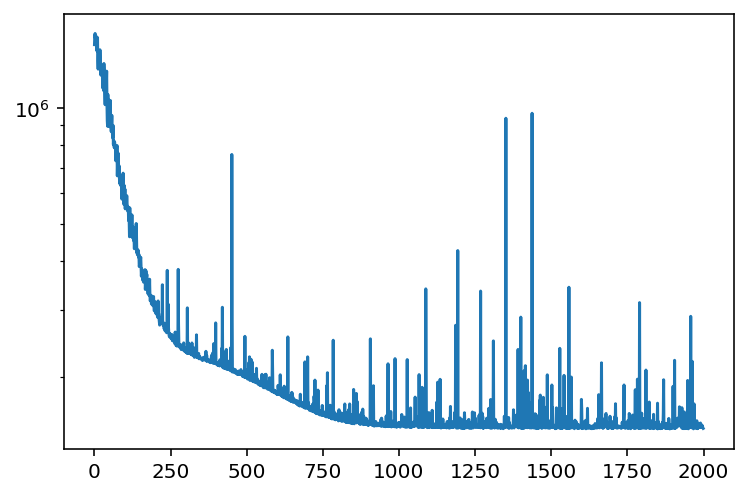

In [211]:
plt.semilogy(svi.loss)

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


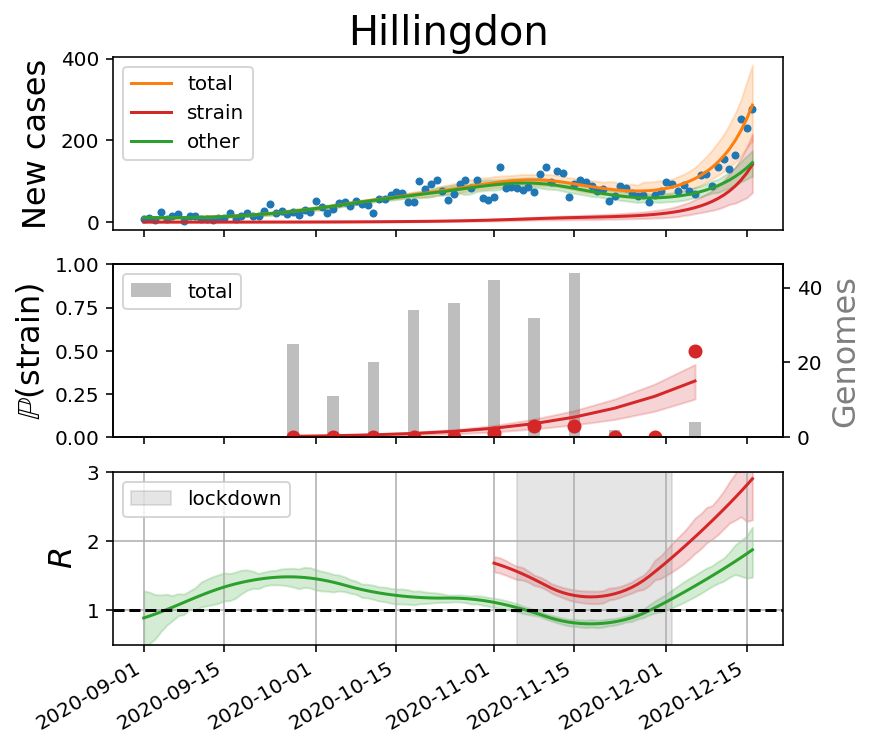

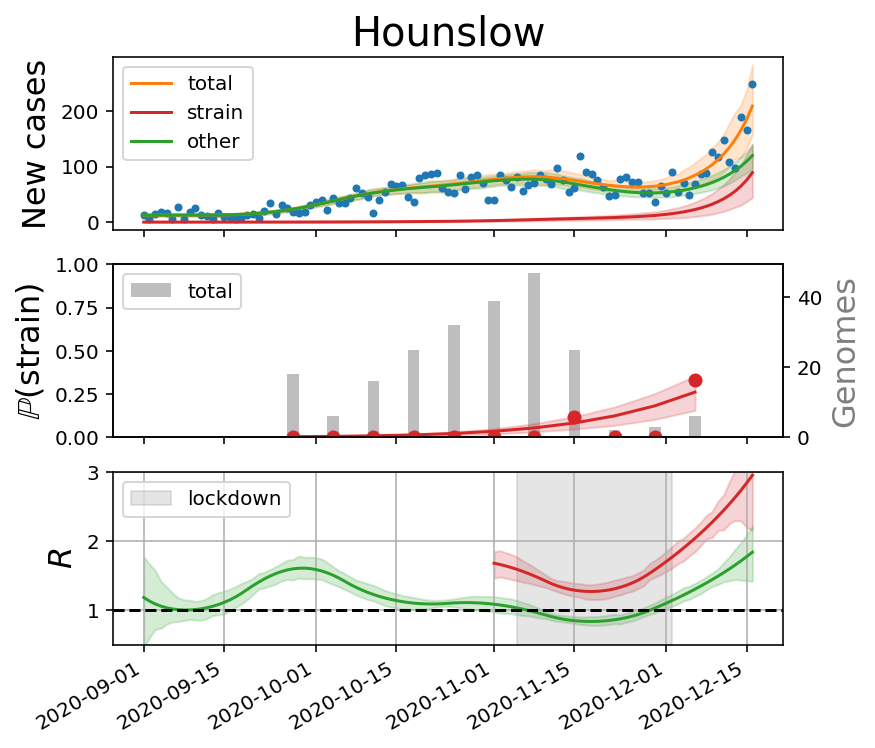

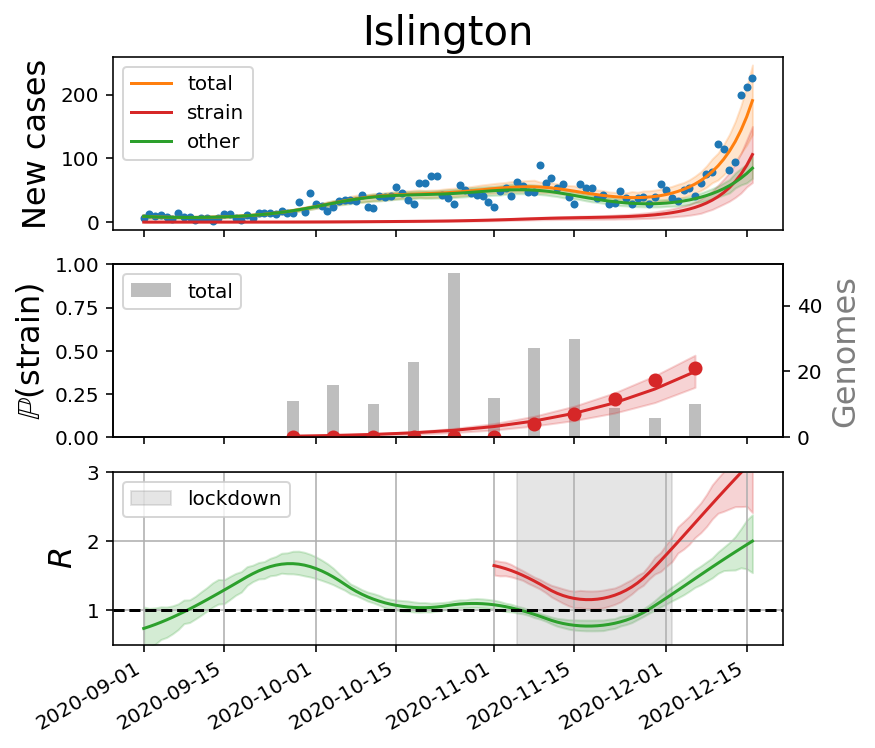

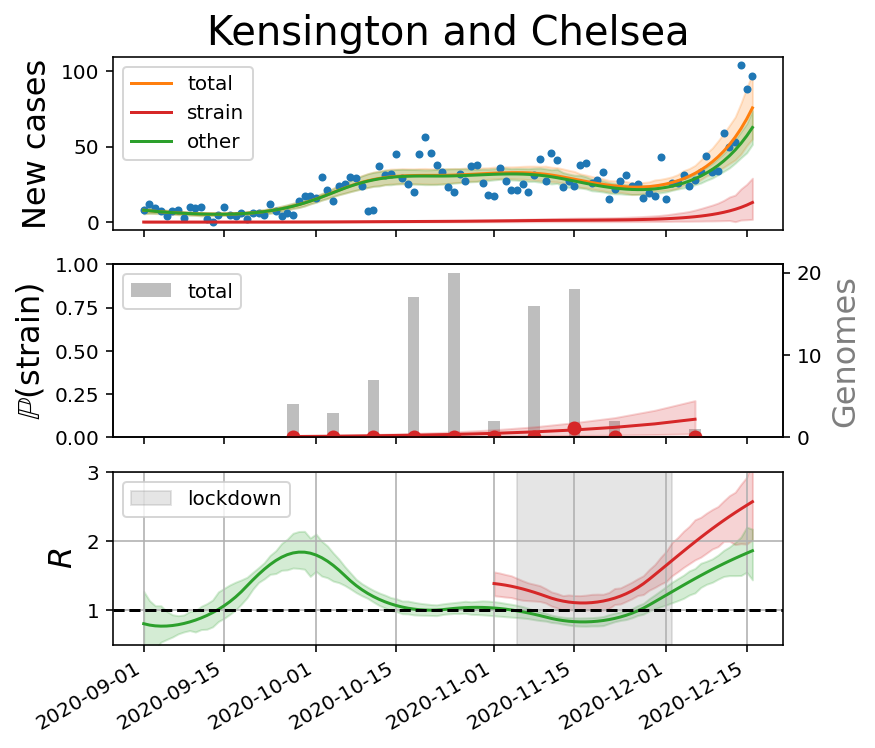

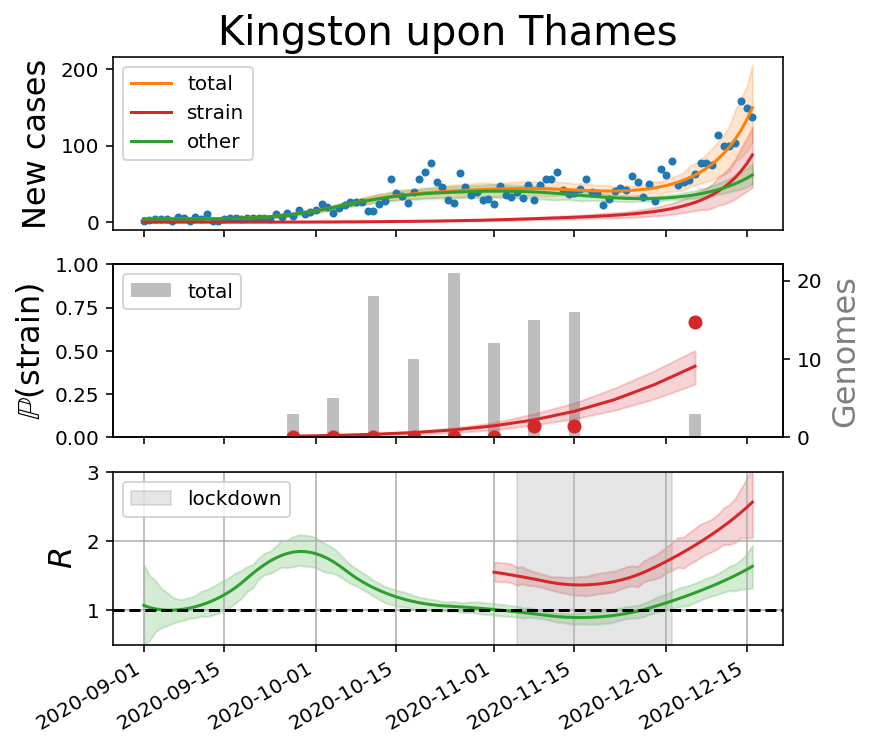

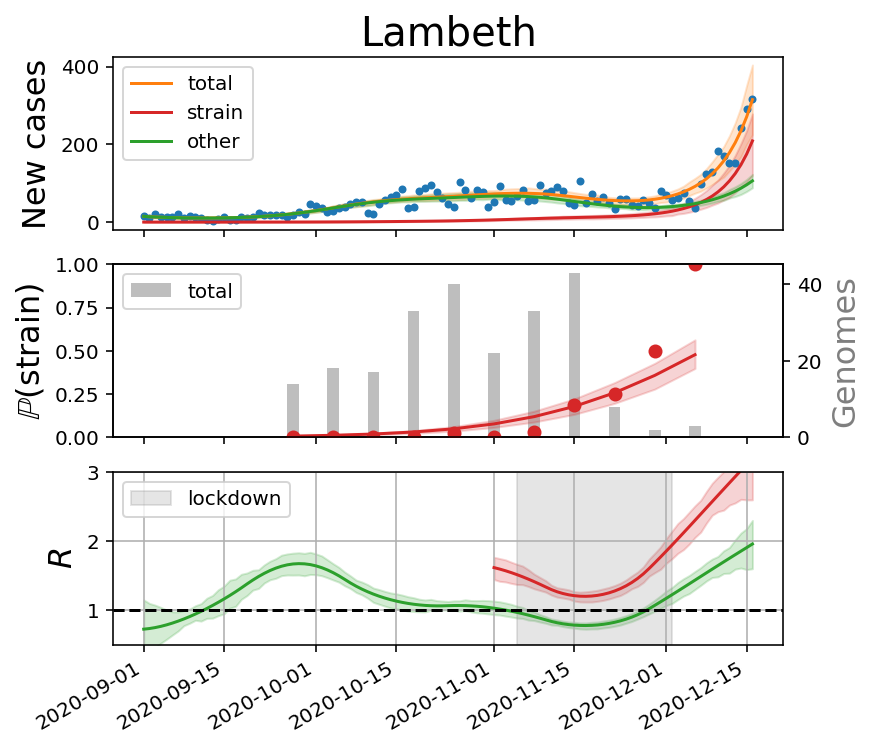

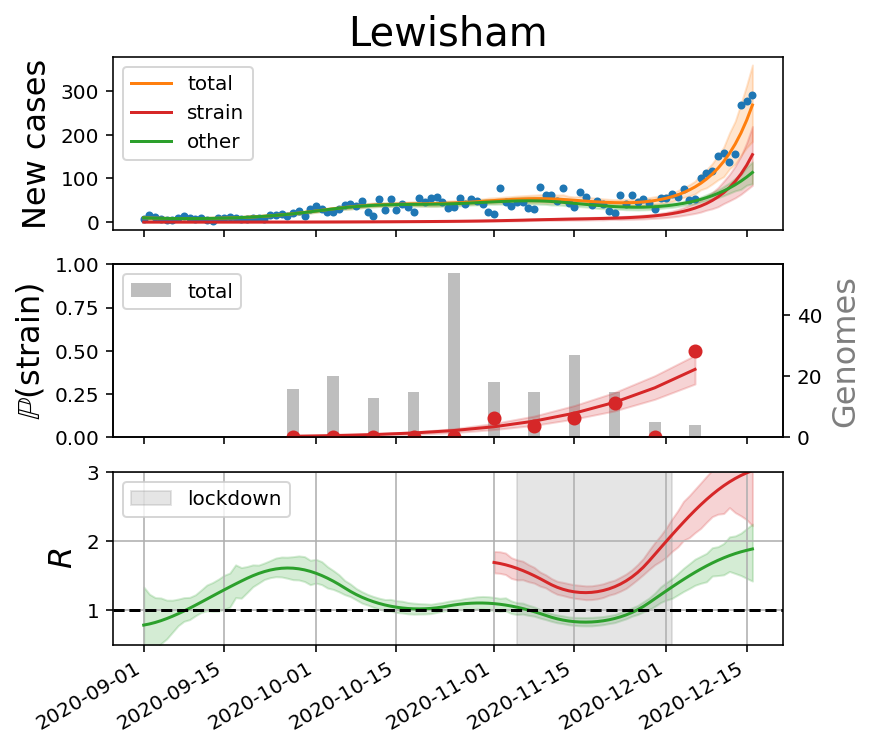

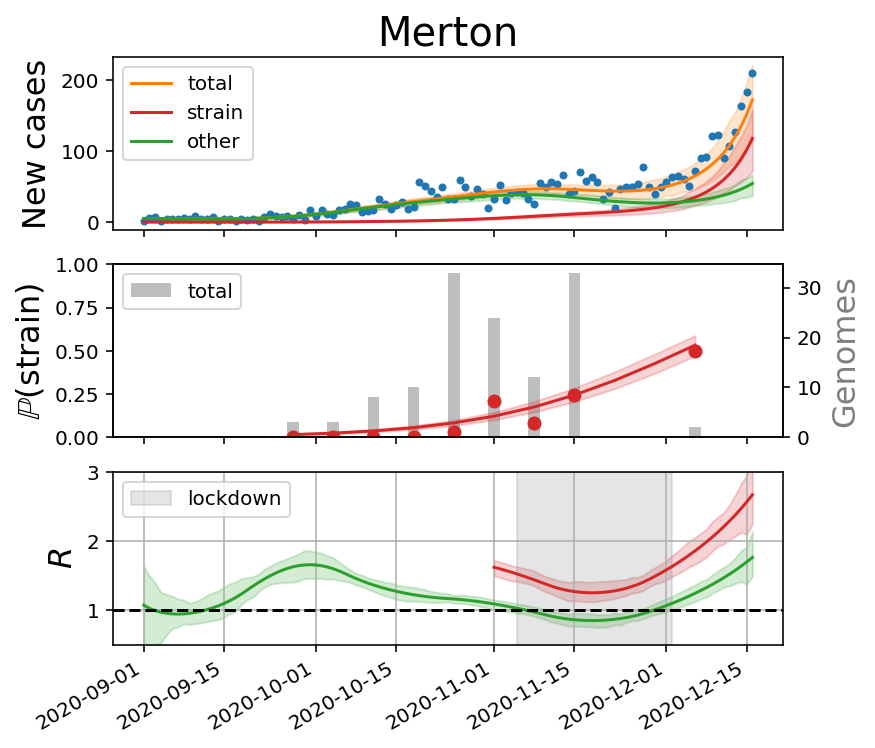

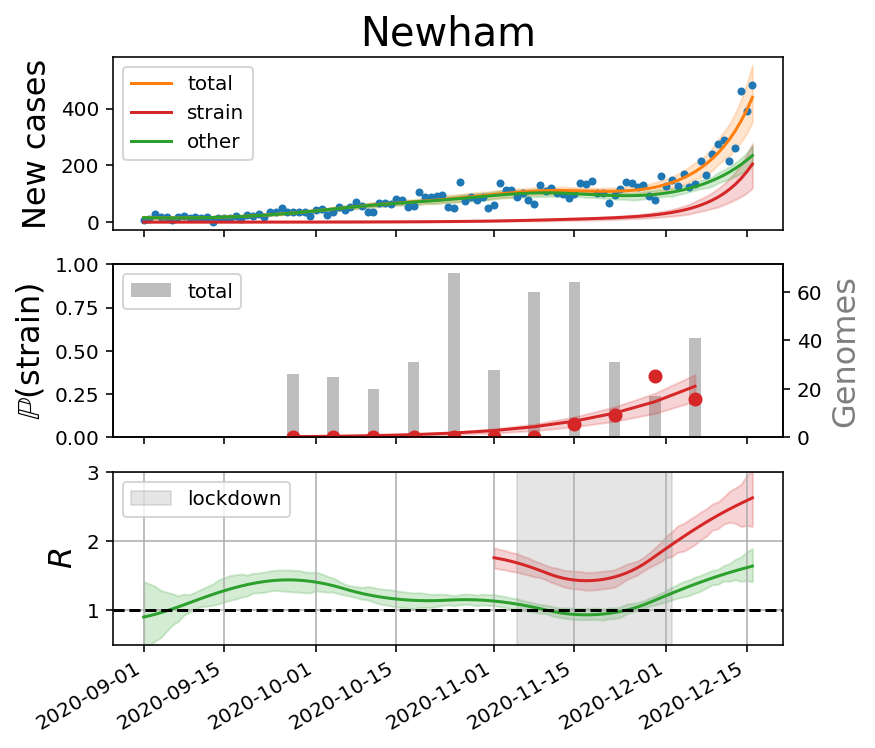

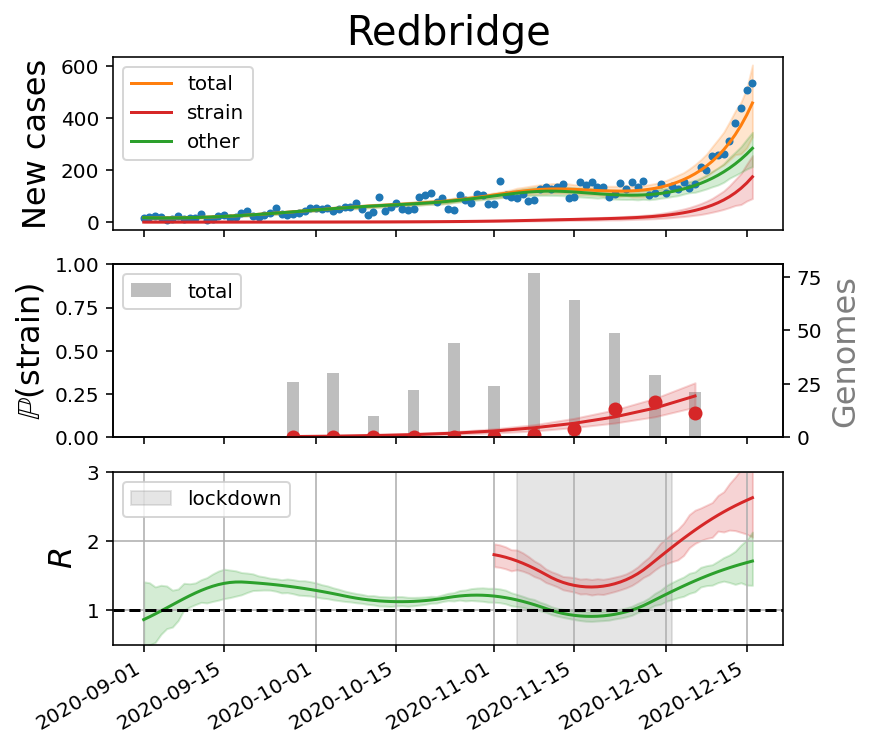

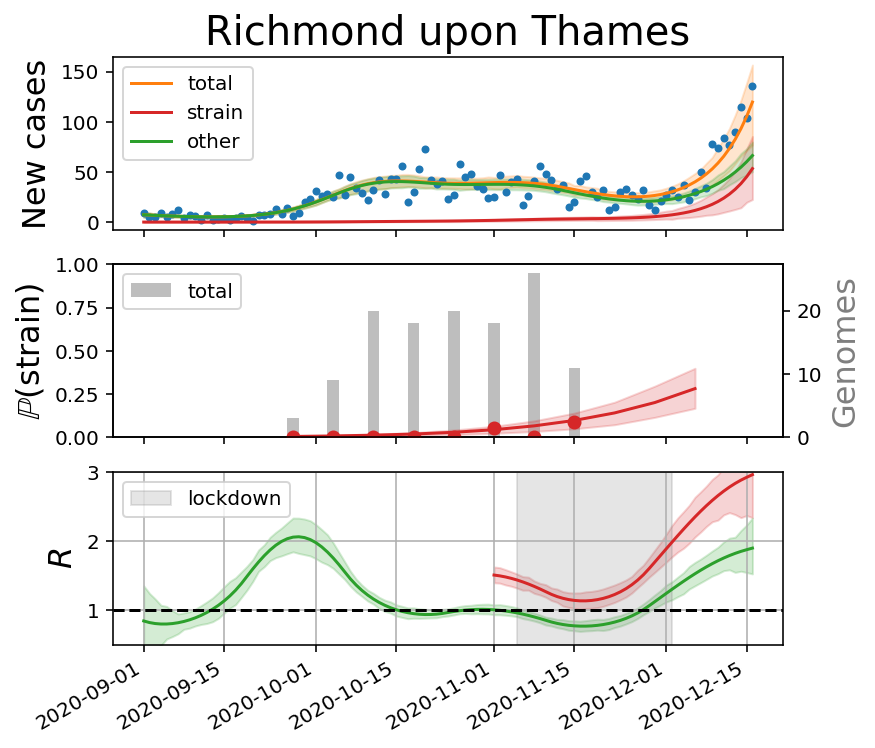

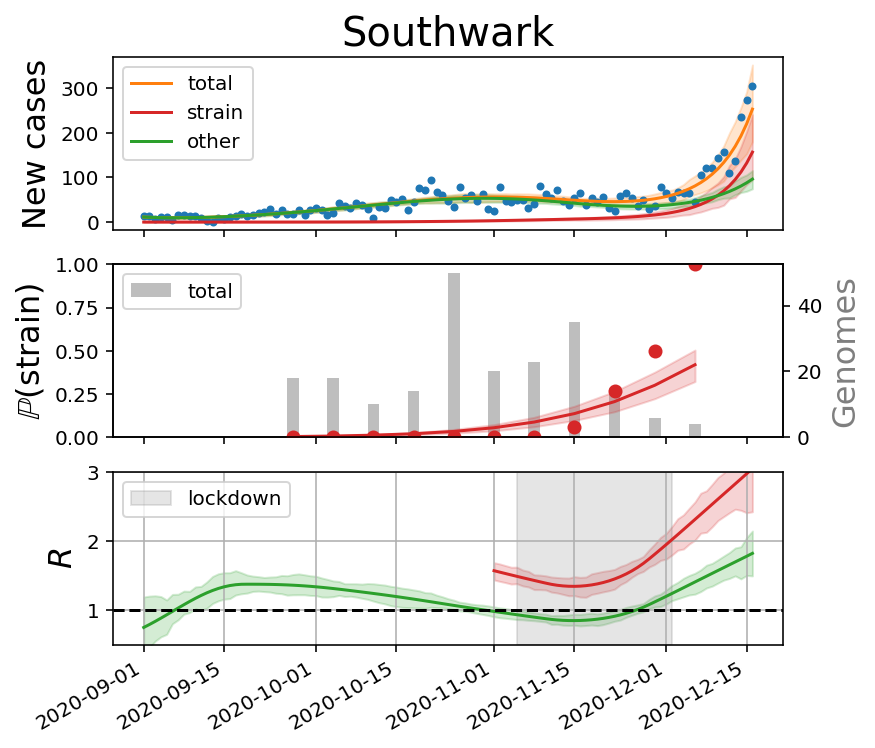

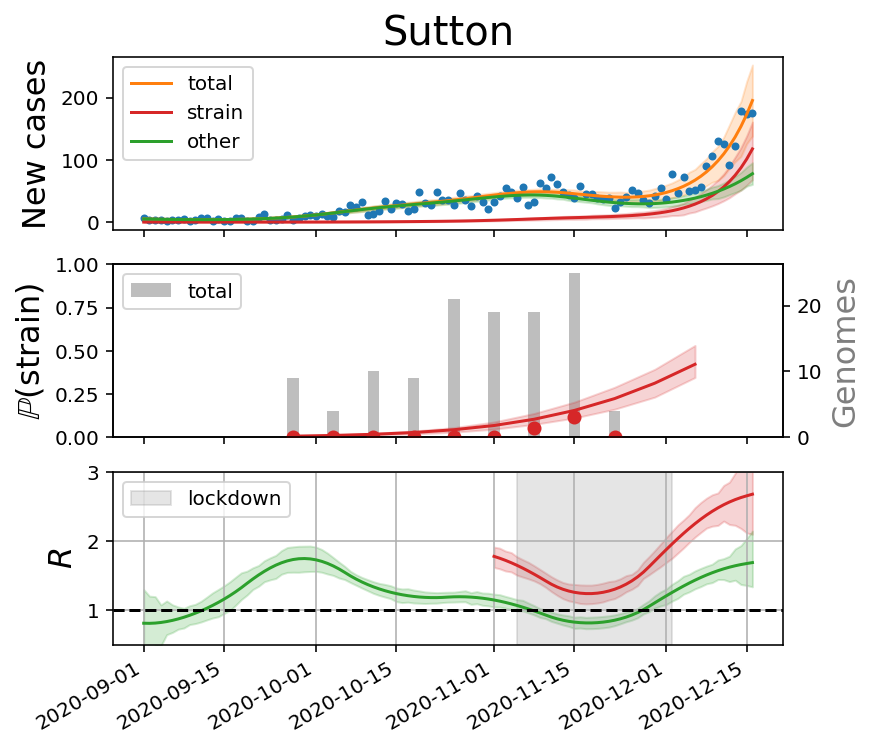

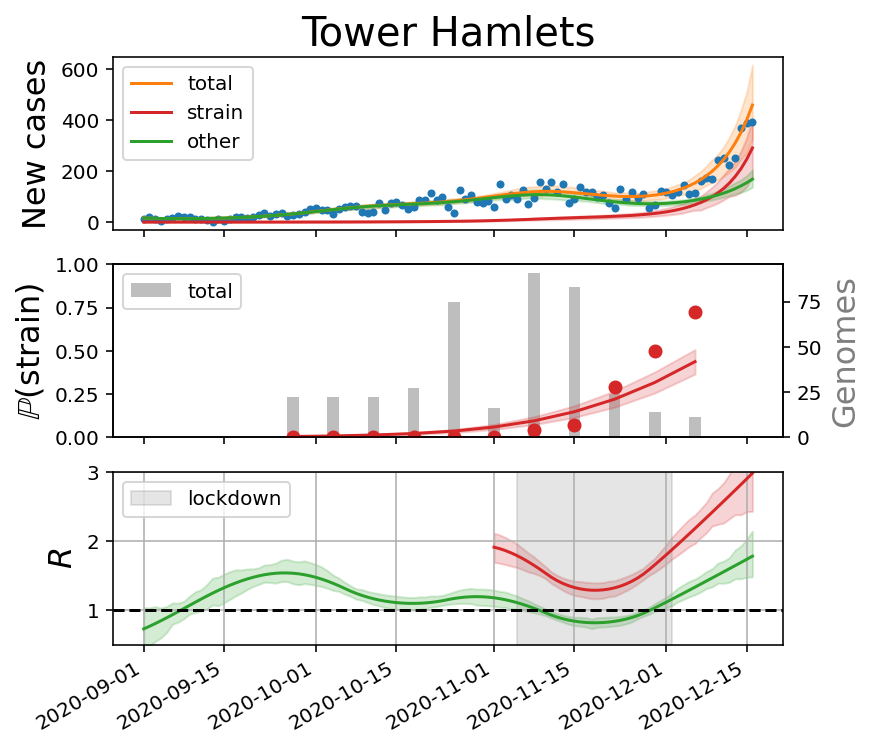

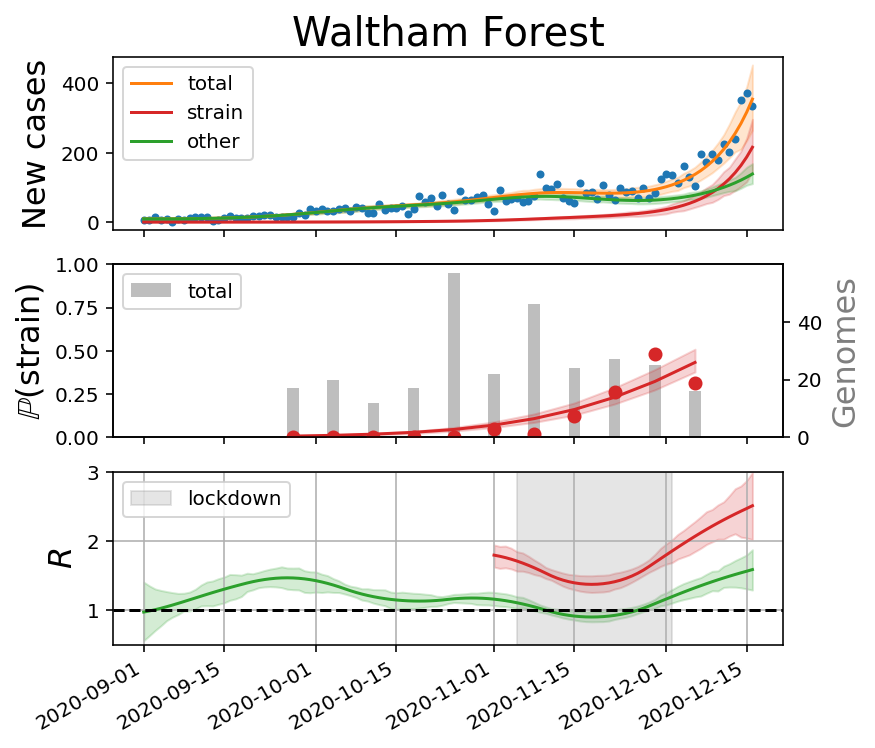

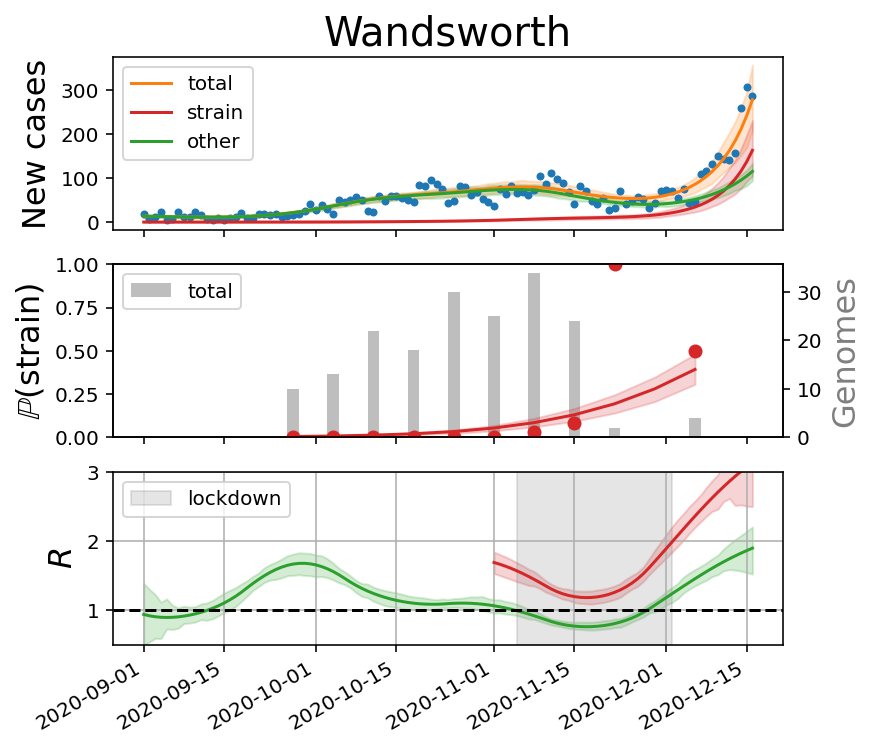

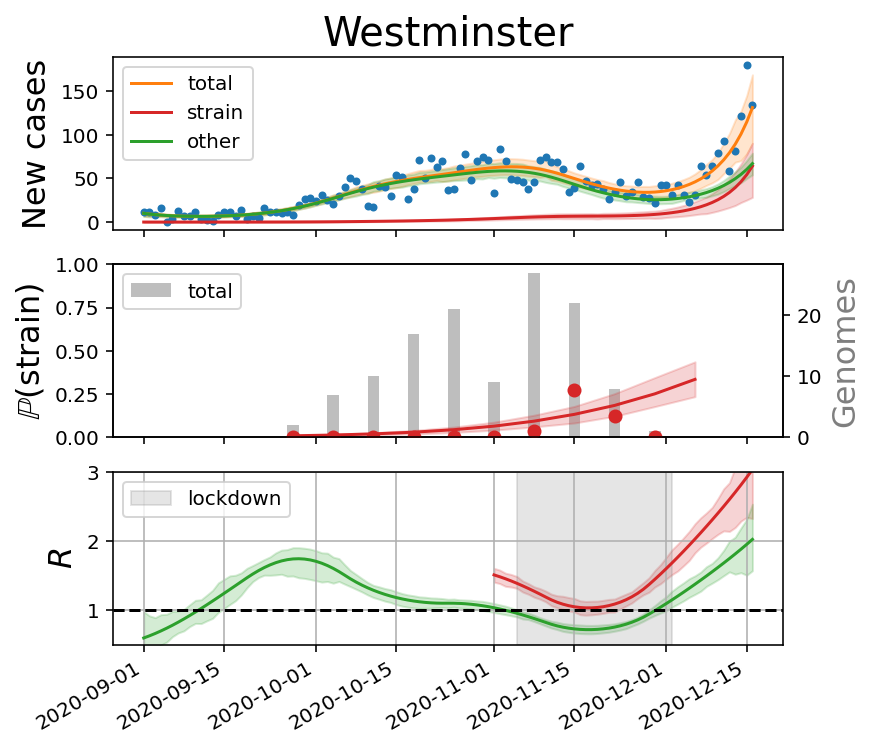

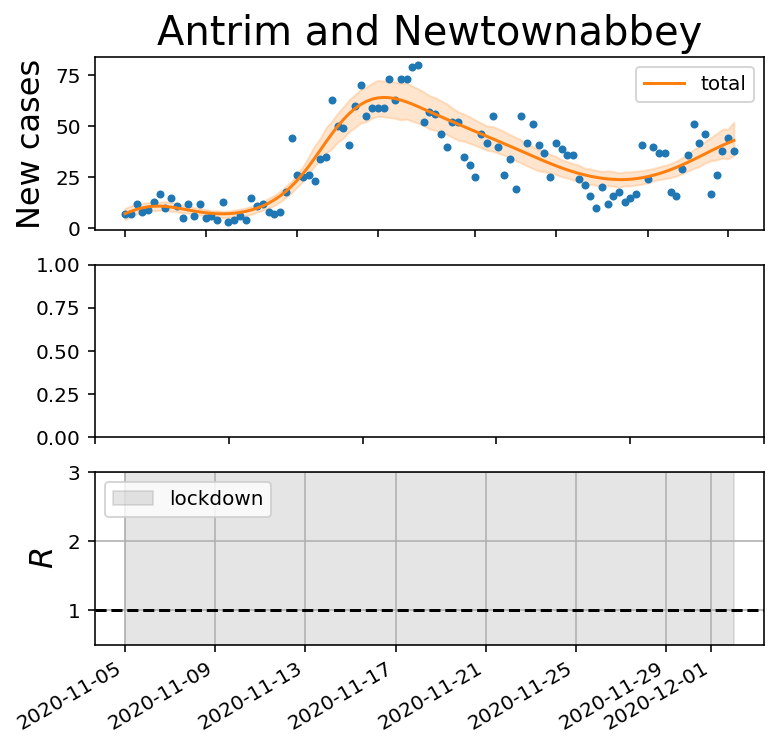

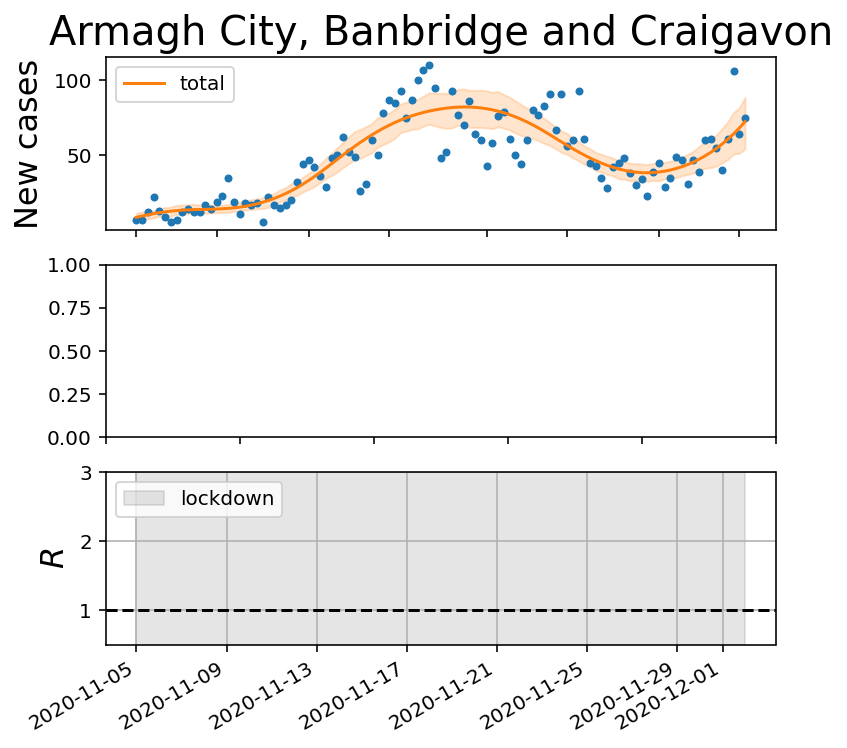

In [248]:
for i in range(300,319):
    try:
        plot(i)
    except:
        pass

In [249]:
np.where(LAD.lad19nm.values == "Manchester")

(array([250]),)

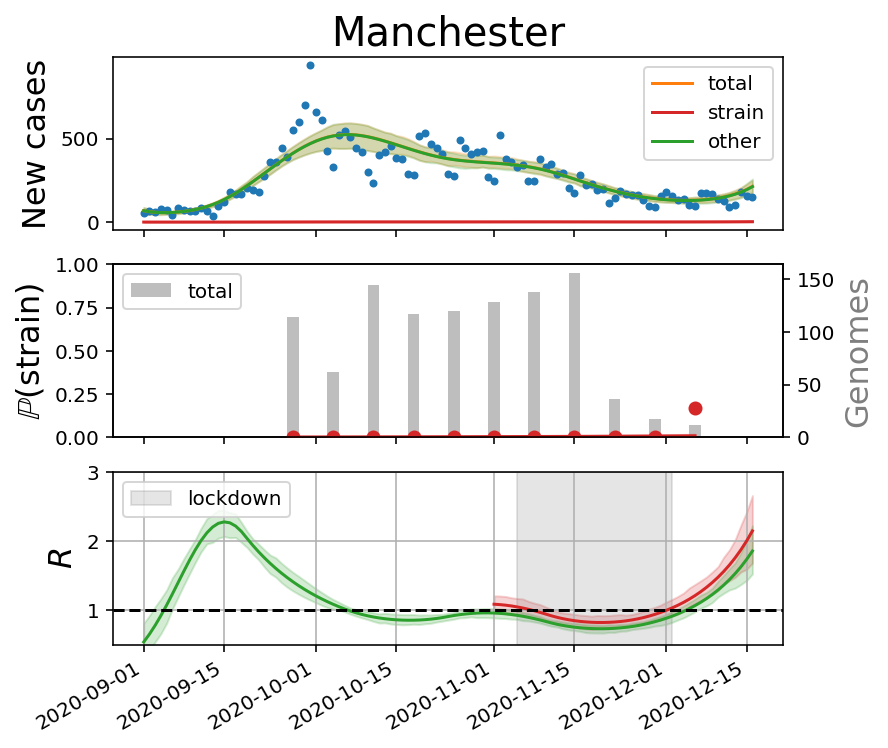

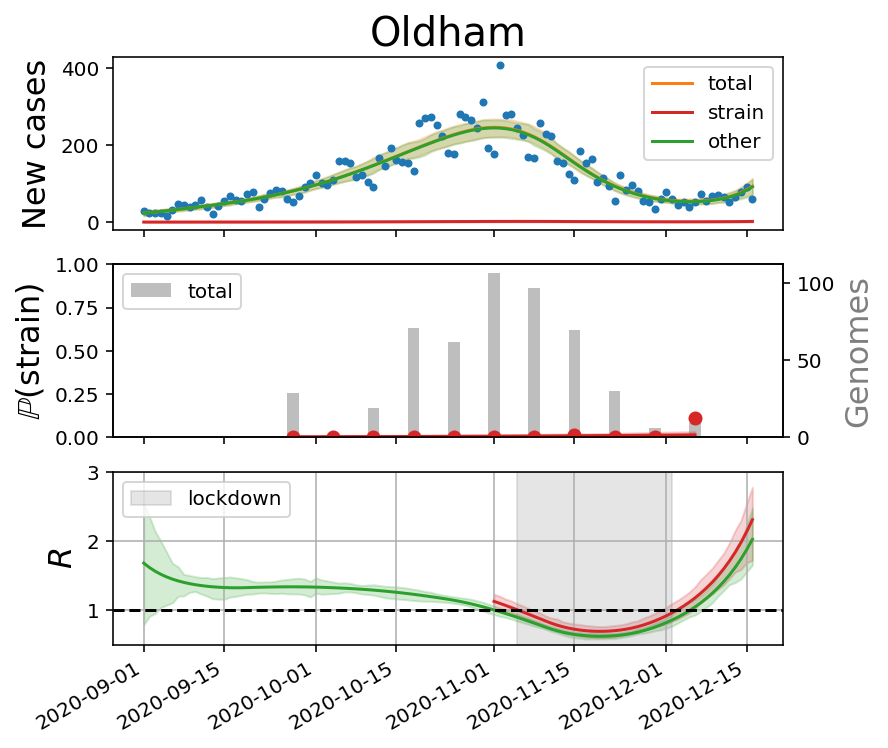

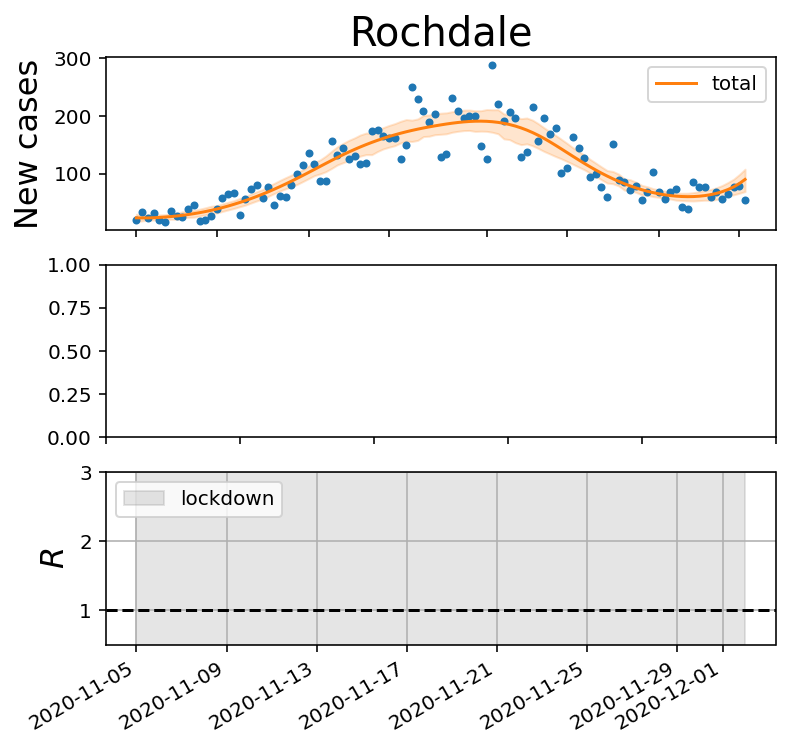

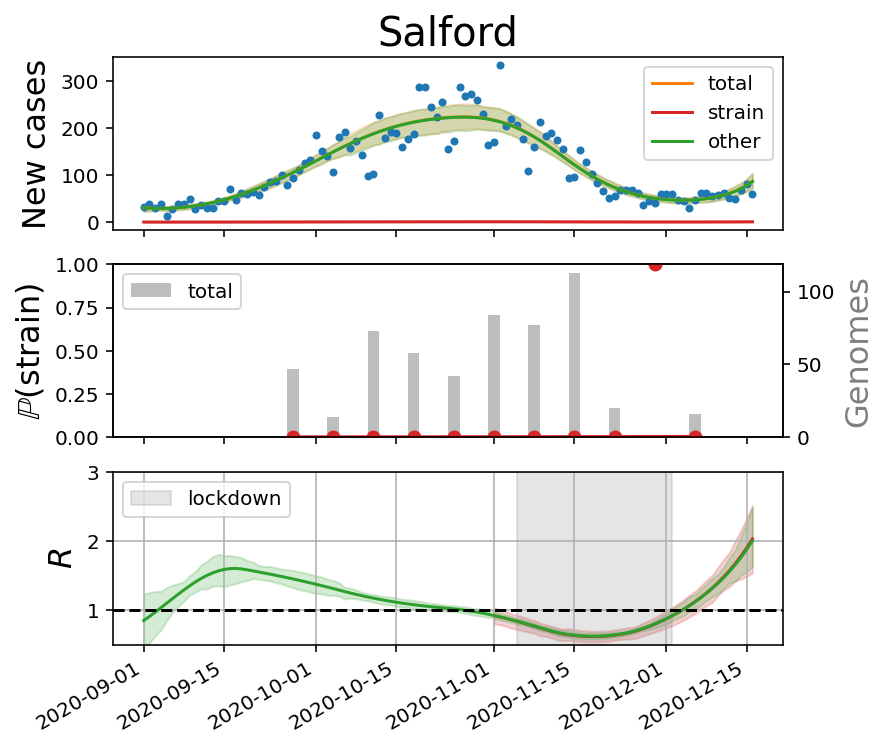

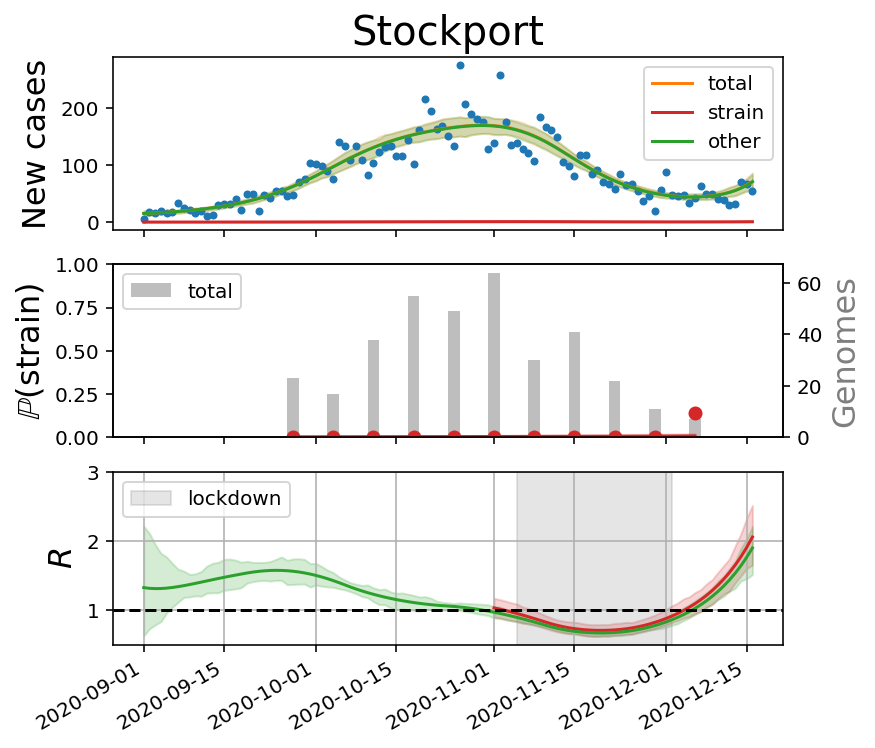

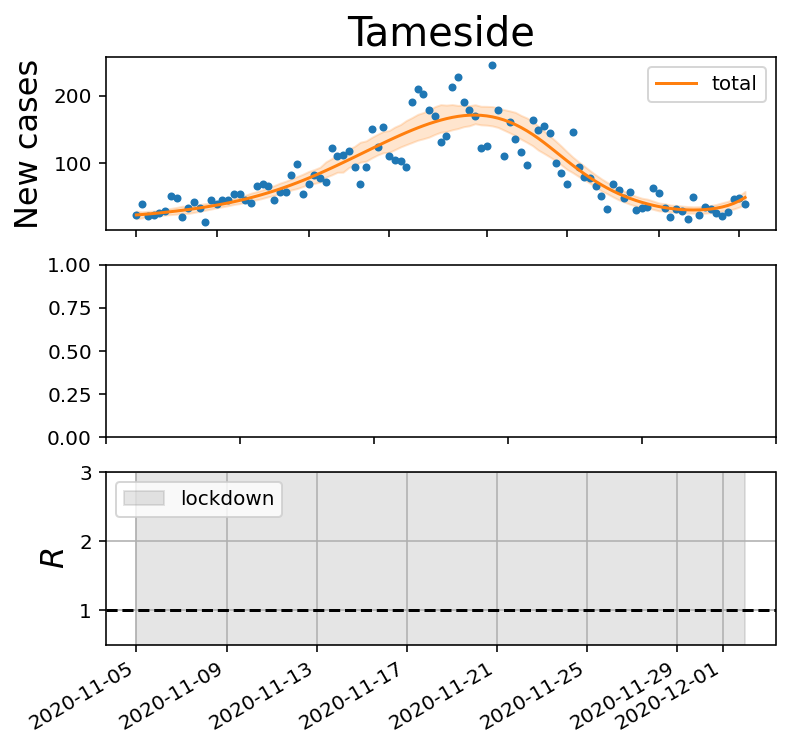

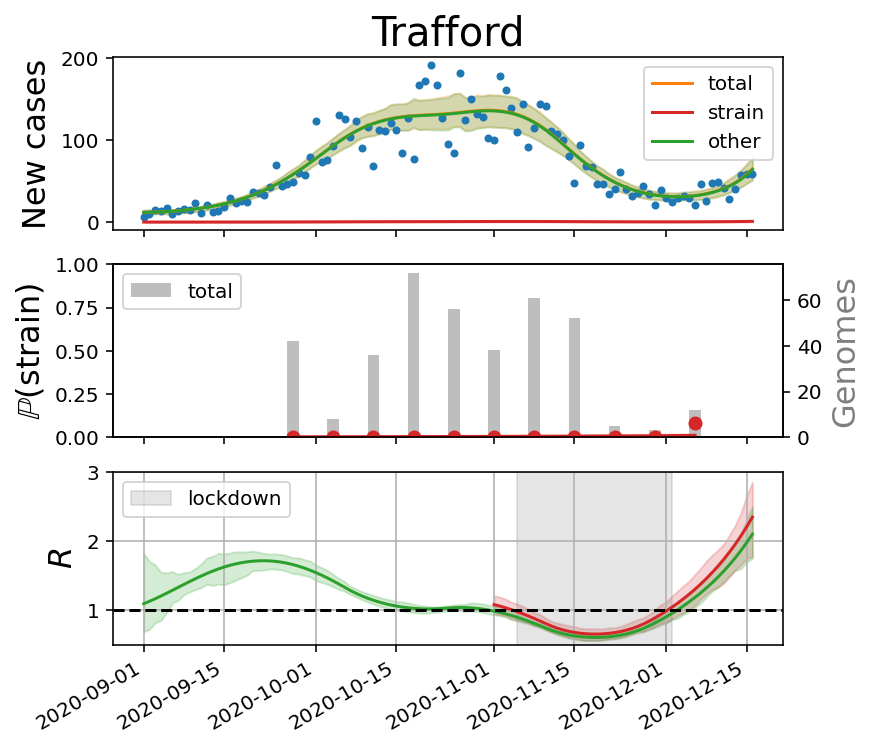

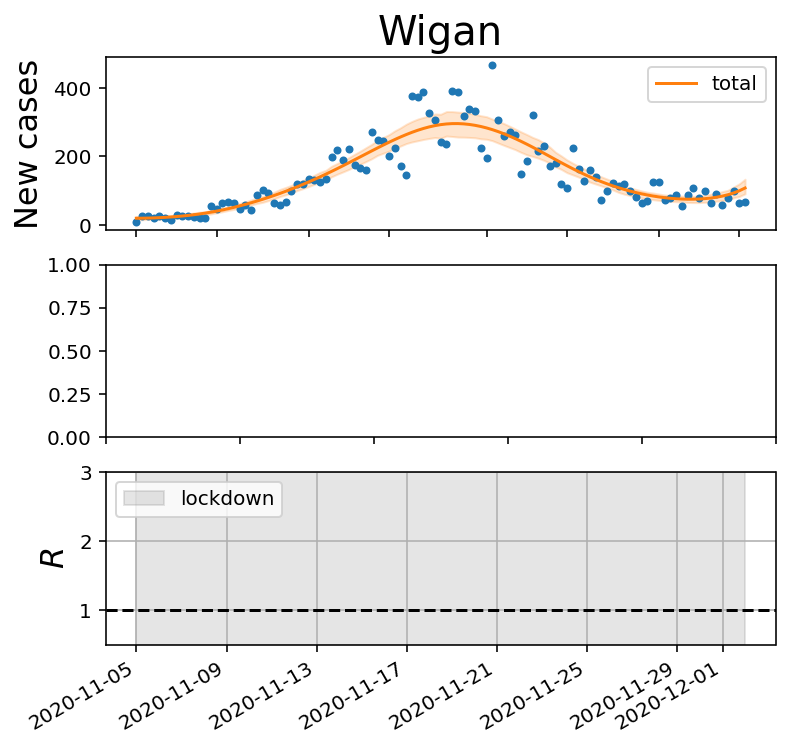

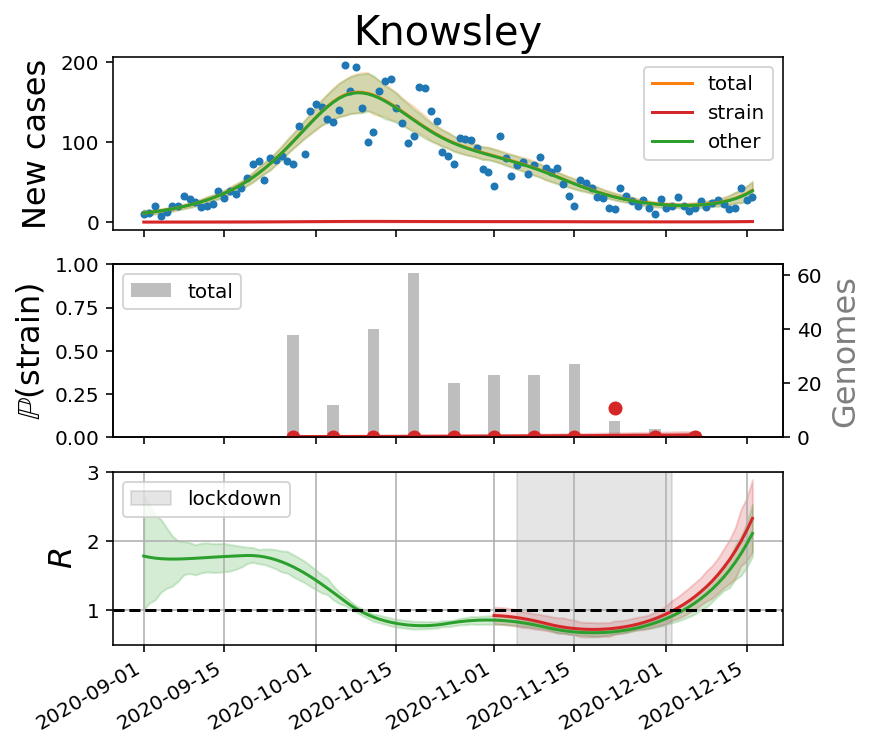

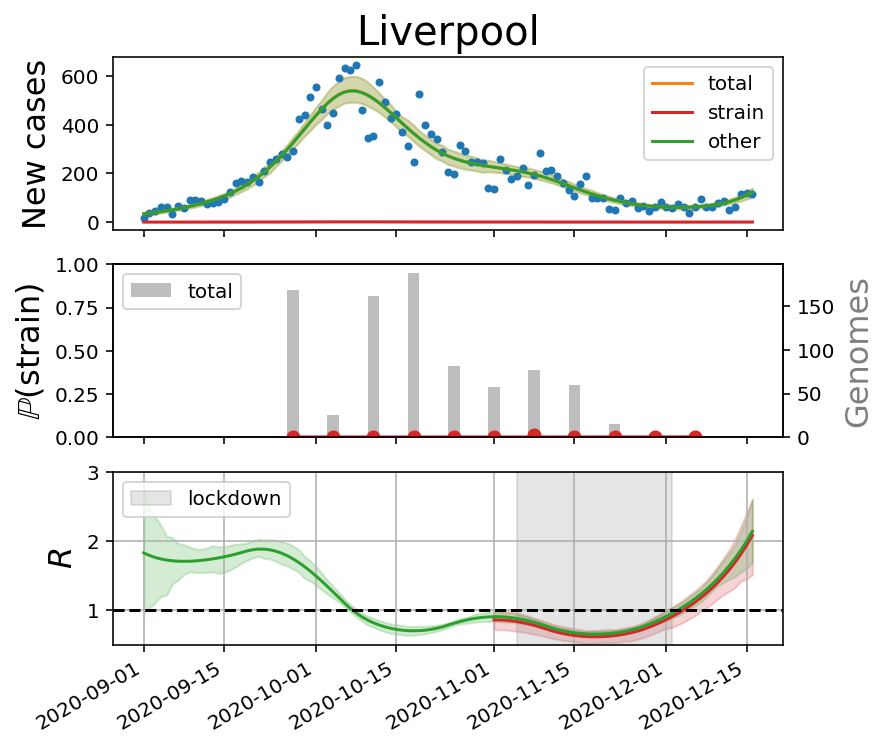

In [250]:
for i in range(250,260):
    try:
        plot(i)
    except:
        pass

In [251]:
np.where(LAD.lad19nm.values == "Thurrock")

(array([31]),)

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


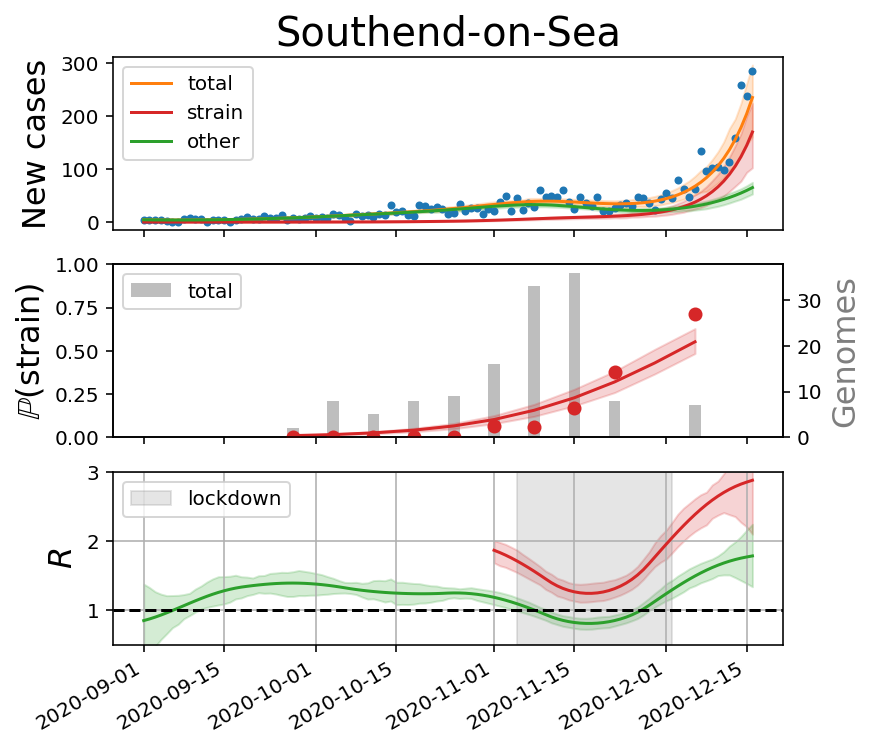

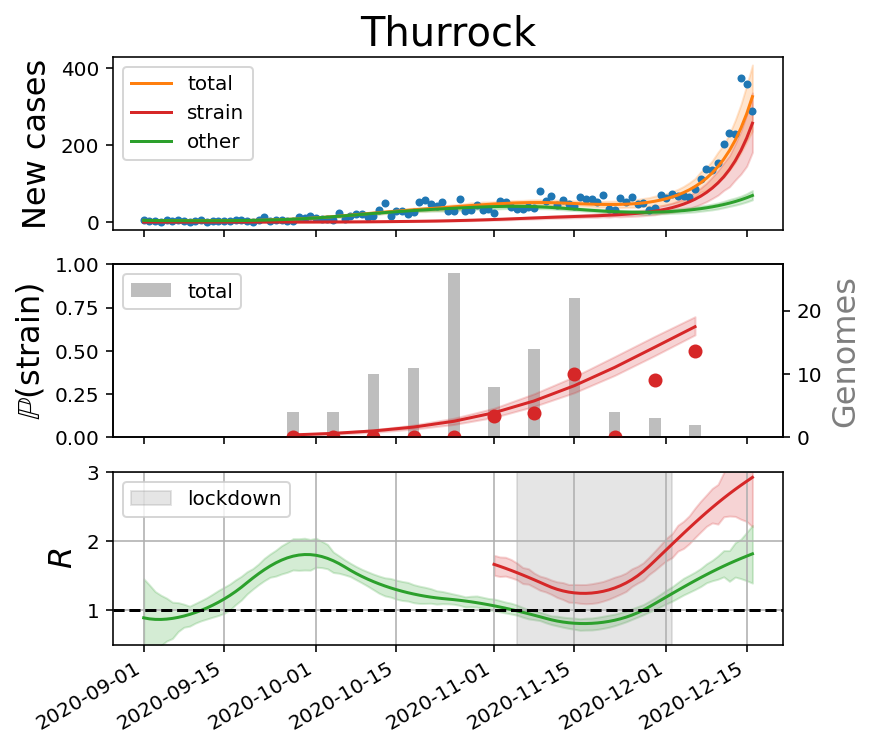

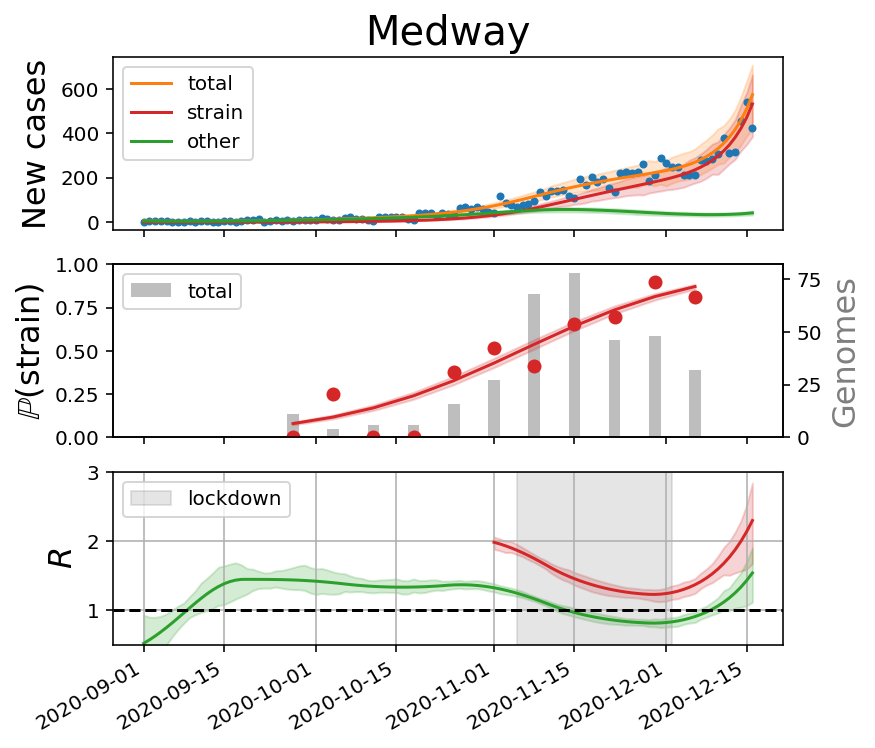

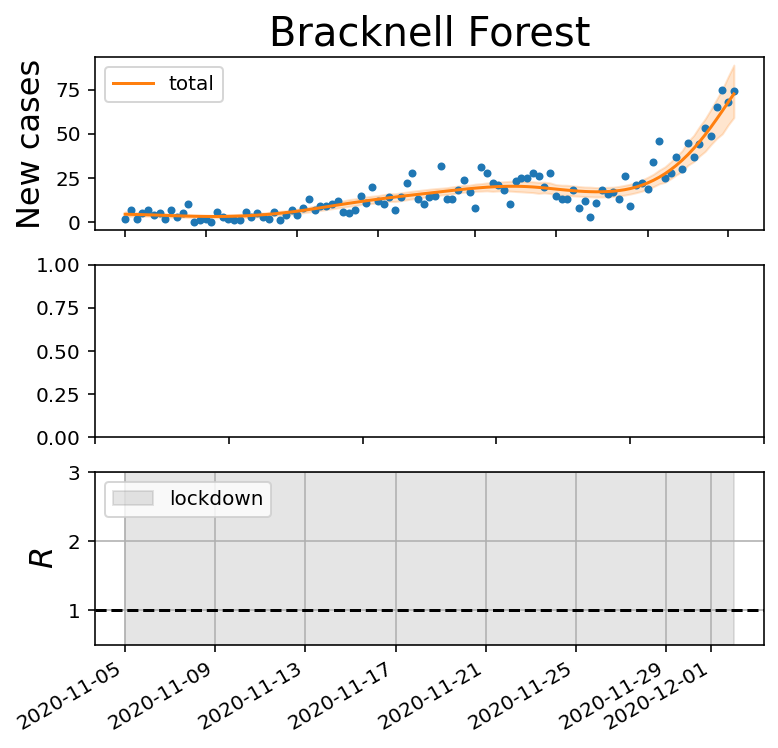

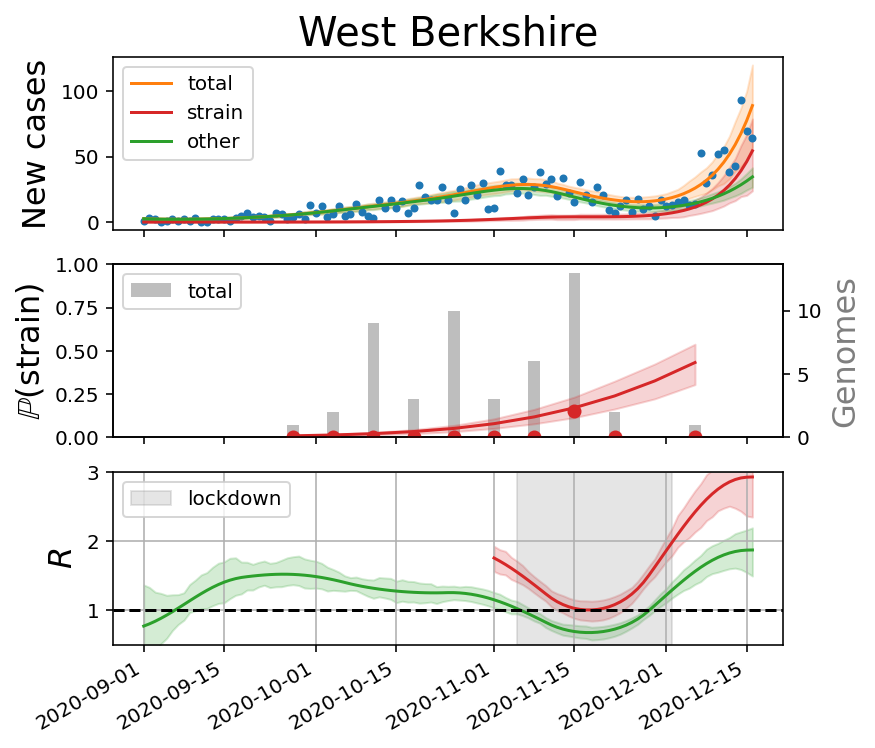

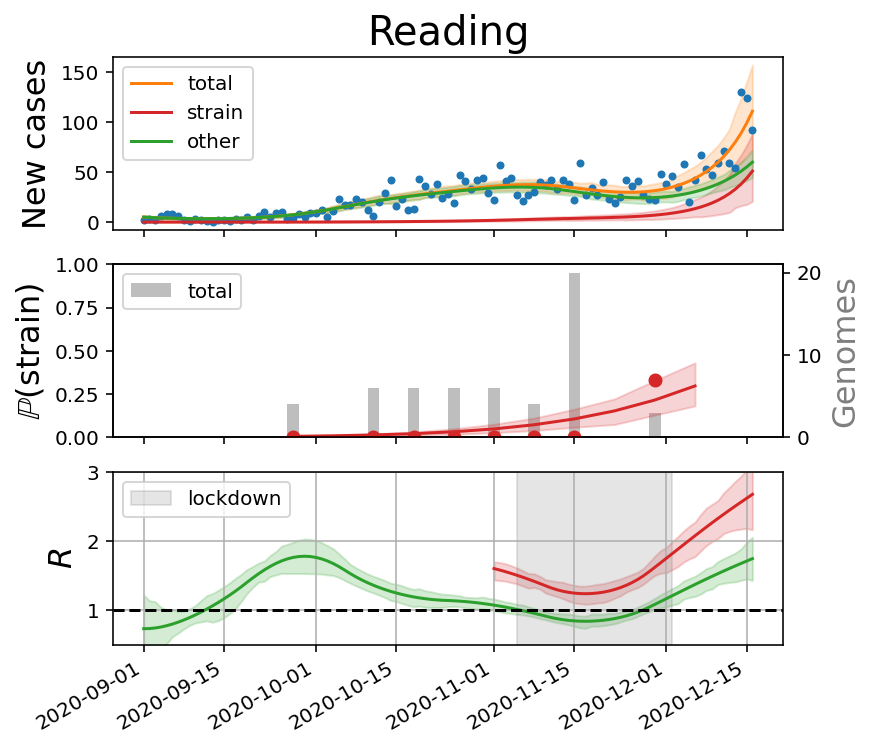

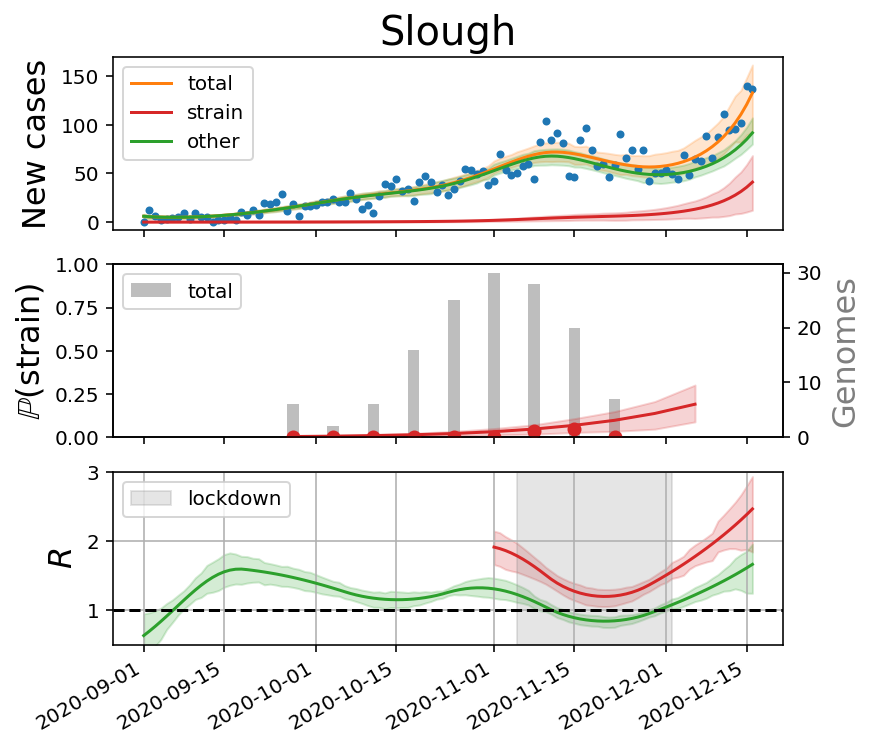

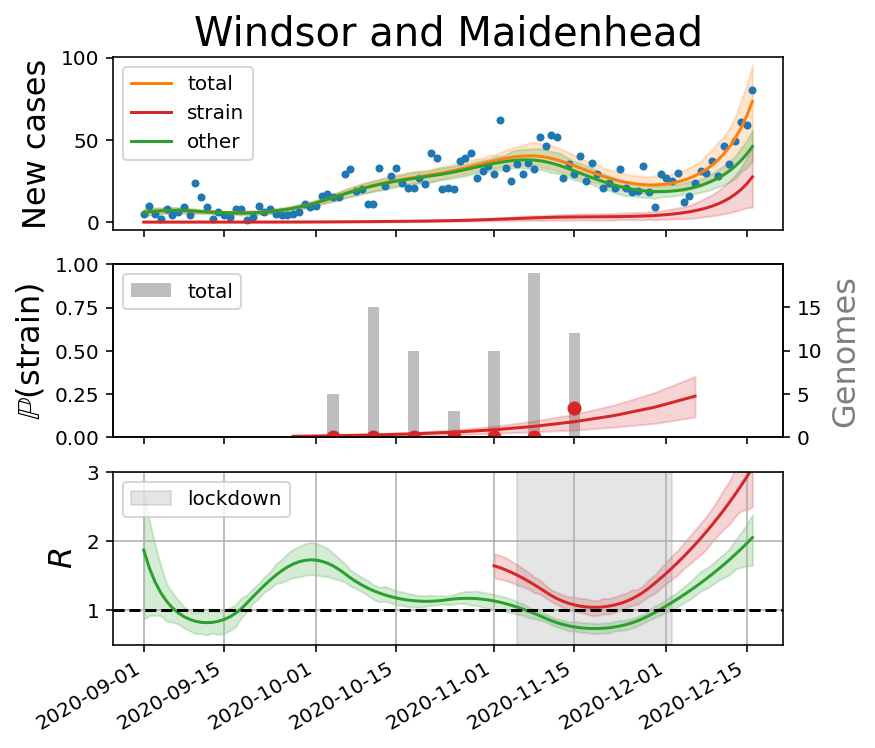

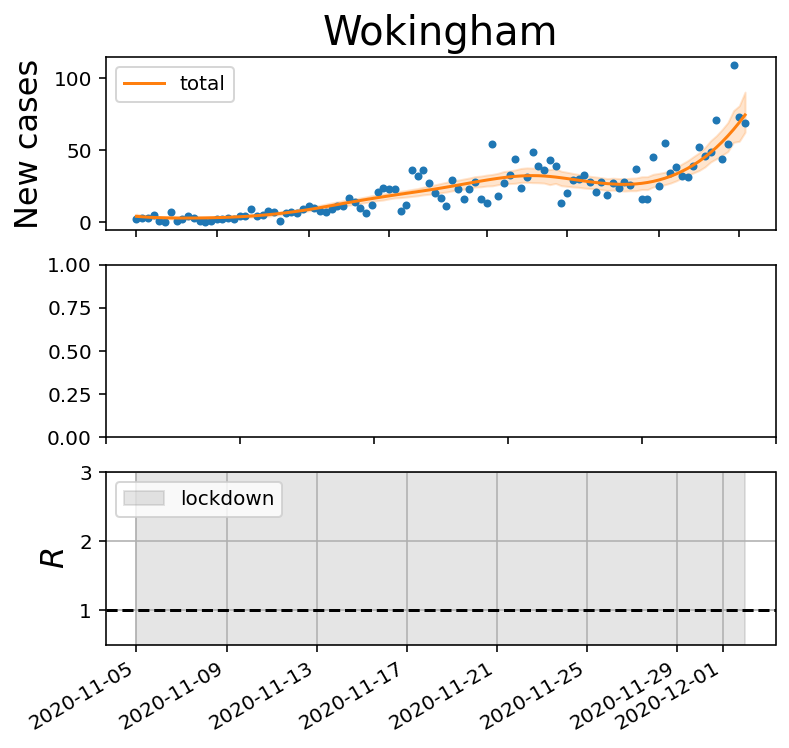

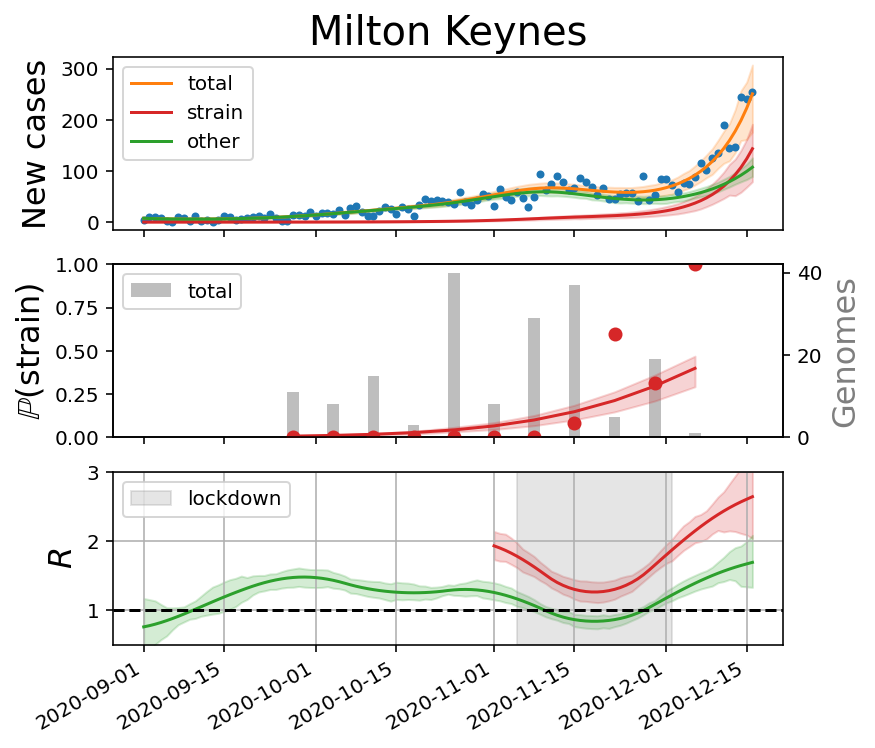

In [252]:
for i in range(30,40):
    try:
        plot(i)
    except:
        pass

In [253]:
np.where(LAD.lad19nm.values == "Cambridge")

(array([60]),)

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


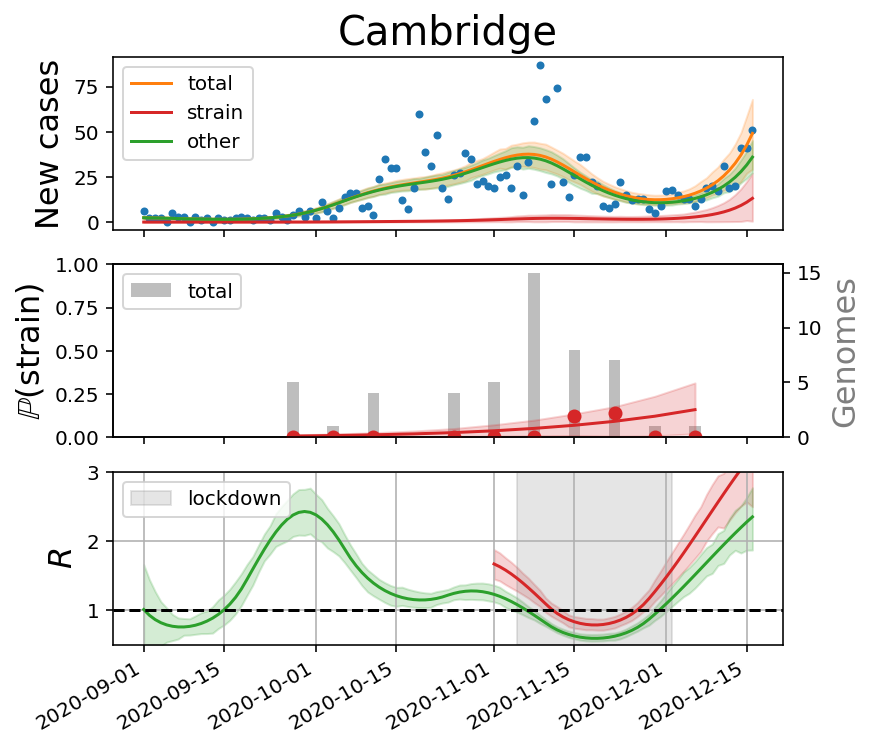

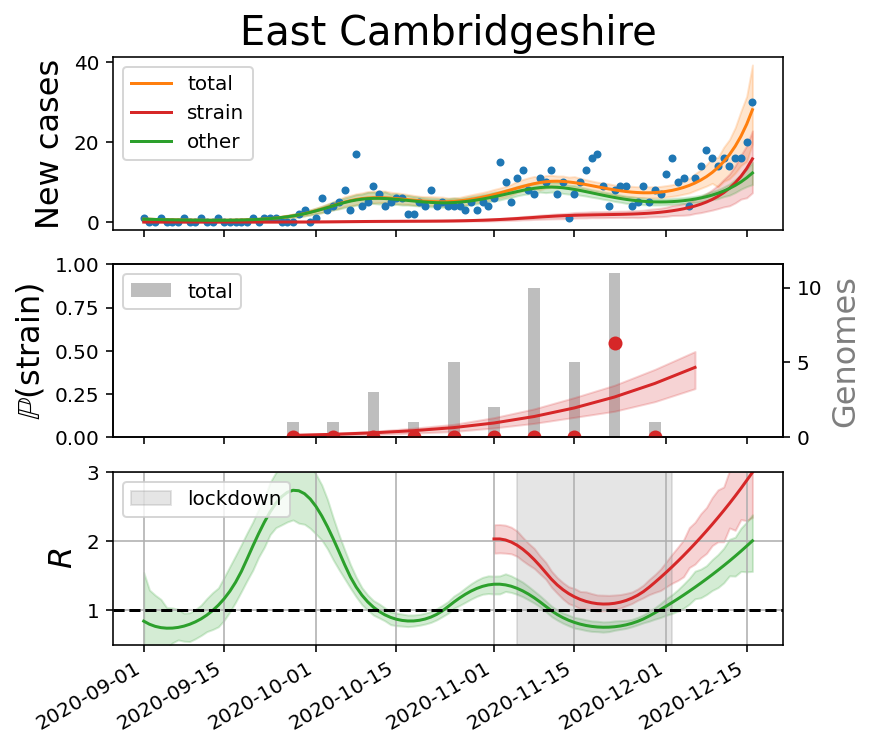

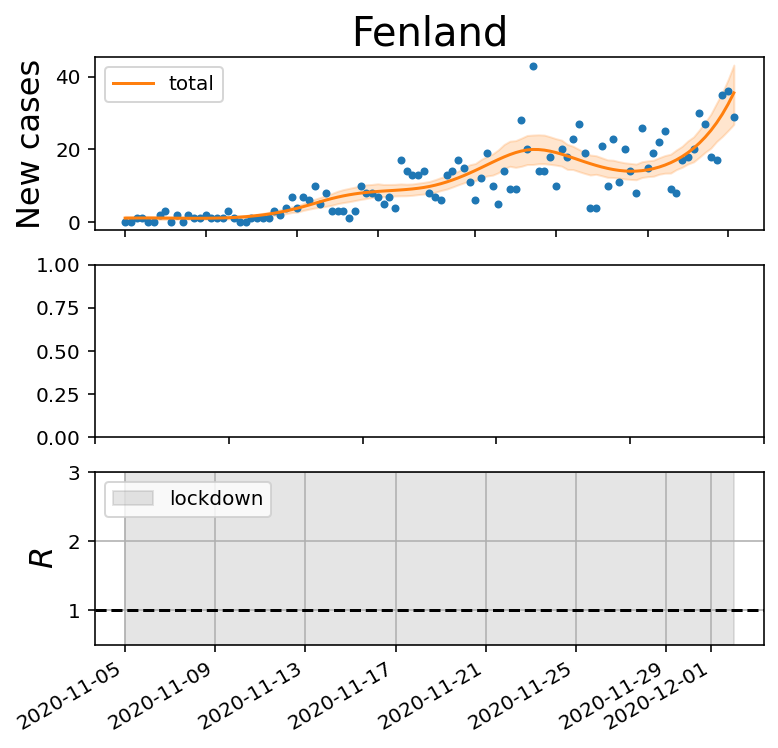

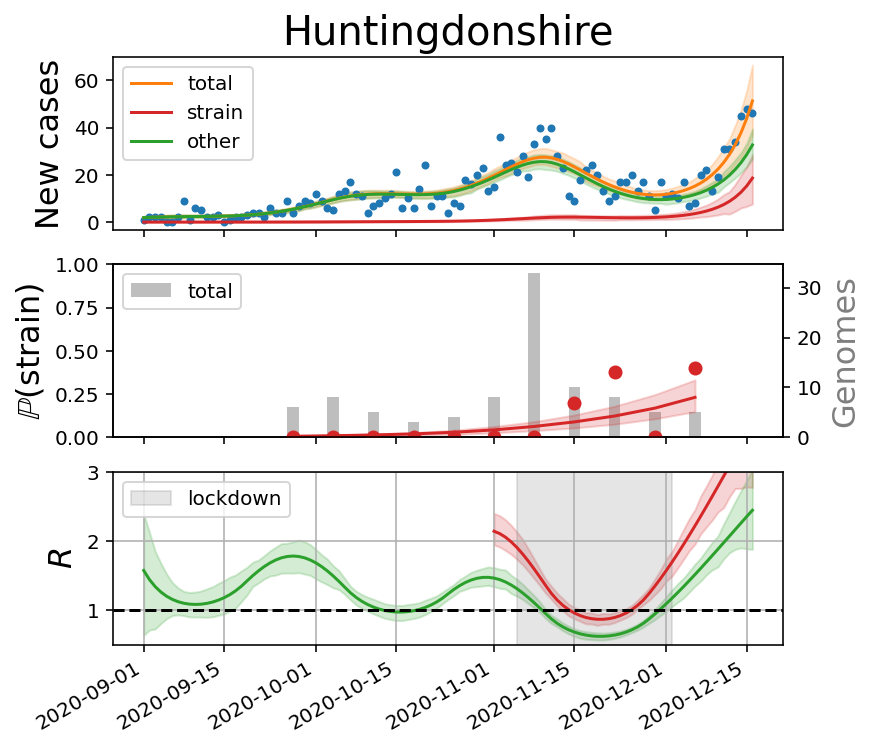

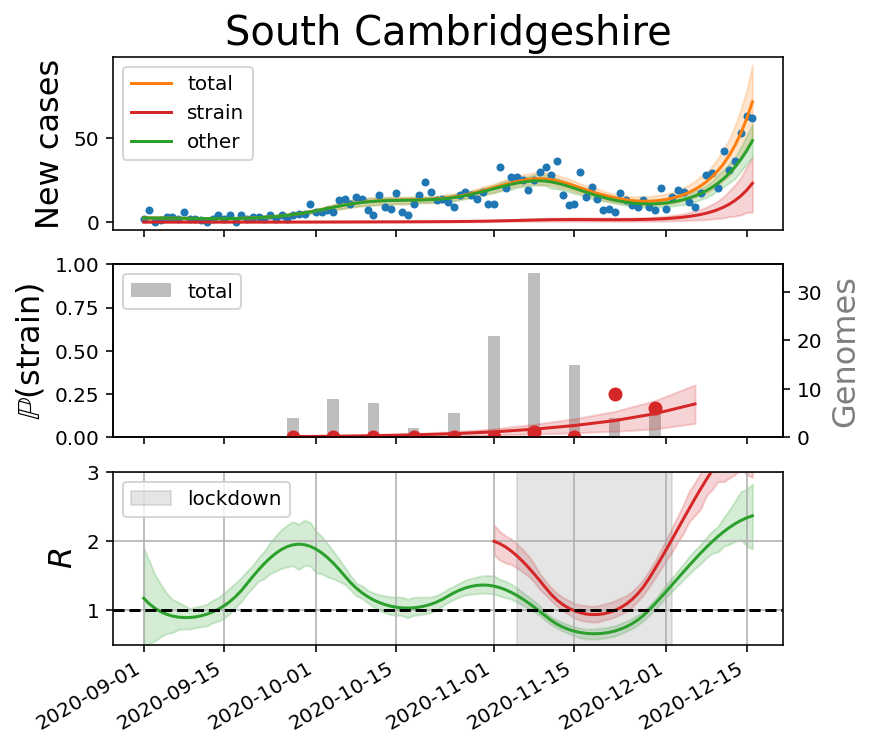

In [254]:
for i in range(60,65):
    try:
        plot(i)
    except:
        pass

In [255]:
R_lockdown0min = np.delete(svi.posterior['R_base'][:,:,65:92].mean(0).min(1), S)
R_lockdownmin = np.array([svi.posterior['R_base'][:,S,65:92].mean(0).min(1), 
            svi.posterior['R_strain'][:,S,65:92].mean(0).min(1)])

<Figure size 432x288 with 0 Axes>

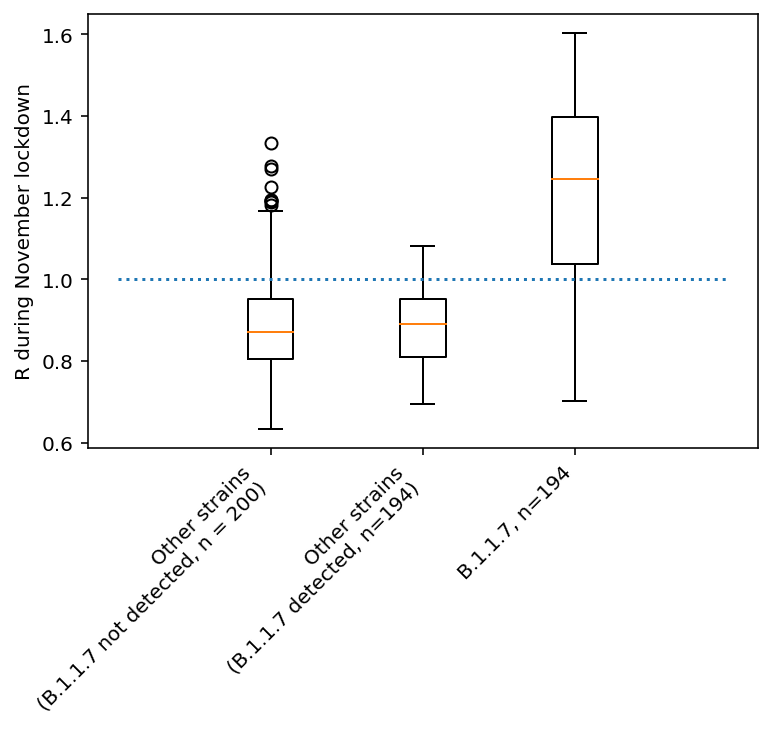

<Figure size 432x288 with 0 Axes>

In [212]:
R_lockdown0 = np.delete(svi.posterior['R_base'][:,:,65:92].mean(2), S, axis=1)
R_lockdown = np.array([svi.posterior['R_base'][:,S,65:92].mean(2), 
            svi.posterior['R_strain'][:,S,65:92].mean(2)])
w = strain[S,:].sum(1)>0
plt.boxplot([R_lockdown0.mean(0), R_lockdown.mean(1)[0,w], R_lockdown.mean(1)[1,w]], positions=range(3))
plt.xticks(range(3), labels = [f"Other strains\n (B.1.1.7 not detected, n = {len(R_lockdown0)})", f"Other strains\n (B.1.1.7 detected, n={len(S)})", f"B.1.1.7, n={len(S)}"], 
           rotation=45, ha="right")
plt.ylabel("R during November lockdown")
plt.plot([-1,3], [1,1], ":")
plt.figure(facecolor="white")
#plt.boxplot()

In [198]:
R_lockdown.shape

(2, 200, 194)

In [48]:
np.quantile(R_lockdown[0,:], [.25,.5,.75])

array([0.81856406, 0.89098233, 0.9450233 ])

In [72]:
np.quantile(R_lockdown[1,:], [.25,.5,.75])

array([1.04494753, 1.22572863, 1.38754183])

In [75]:
(R_lockdownmin[1,:] > 1 ).mean()

0.5463917525773195

In [215]:
def pivot_table(X, v):
    return np.array([(X==vv).sum() for vv in v])

In [265]:
w = strain[S,:6].sum(1)>-1
escape =  (R_lockdown > 1 )
e = np.einsum('i,ijk',np.arange(1,3), escape)
p = np.array([pivot_table(X, range(4)) for X in e[...,w]])

([<matplotlib.axis.XTick at 0x7f9273aadf10>,
 [Text(1, 0, 'Both controlled'),
  Text(2, 0, 'Only other strains escape'),
  Text(3, 0, 'Only B.1.1.7 escapes'),
  Text(4, 0, 'All escape')])

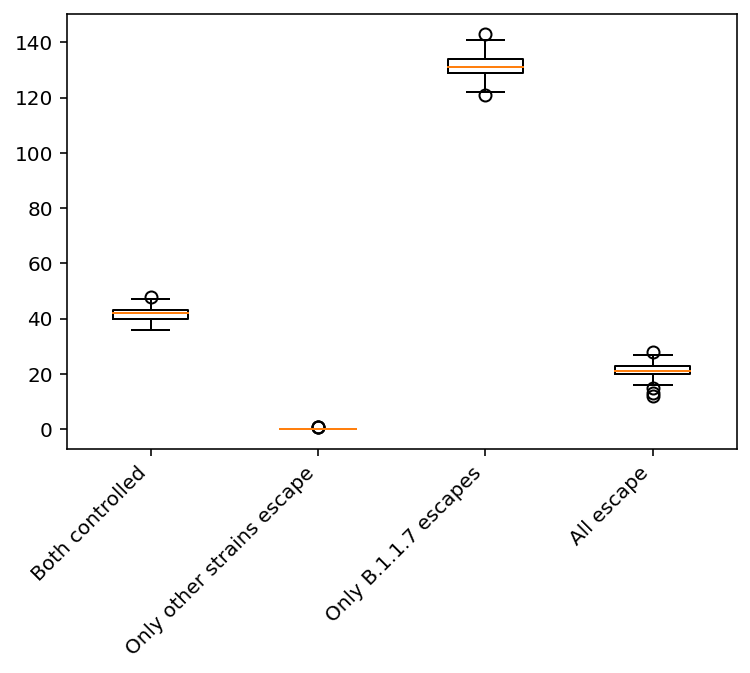

In [266]:
plt.boxplot(p)
plt.xticks(range(1,5), labels = ["Both controlled", "Only other strains escape", "Only B.1.1.7 escapes", "All escape"], 
           rotation=45, ha="right")

In [353]:
np.quantile(p,[.025,.5,.975], axis=0)/194

array([[0.19072165, 0.        , 0.63904639, 0.08247423],
       [0.21649485, 0.        , 0.67525773, 0.10824742],
       [0.2371134 , 0.        , 0.71134021, 0.13917526]])

In [70]:
np.mean((R_lockdown[0,:] < 1 ) * (R_lockdown[1,w] > 1 ))

0.7422680412371134

In [269]:
R_lockdown.shape

(2, 200, 194)

Text(0.99, 0.01, 'B.1.1.7 controlled\nother escaped')

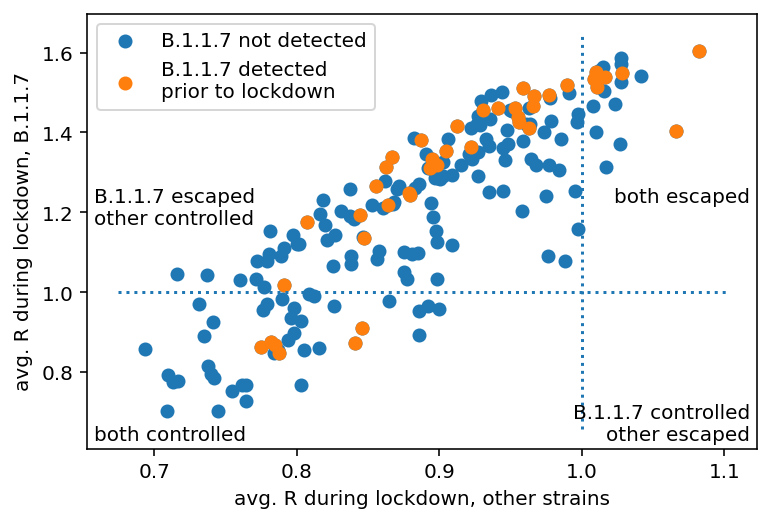

In [321]:
w = np.where(strain[S,:6].sum(1)>0)[0]
plt.figure(facecolor="white")
ax = plt.axes()
plt.scatter(R_lockdown.mean(1)[0,], R_lockdown.mean(1)[1,], label="B.1.1.7 not detected")
plt.scatter(R_lockdown.mean(1)[0,w], R_lockdown.mean(1)[1,w], label="B.1.1.7 detected\nprior to lockdown")
plt.legend()
plt.xlabel("avg. R during lockdown, other strains")
plt.ylabel("avg. R during lockdown, B.1.1.7")
#plt.plot([.5,1.5], [.5, 1.5],":")
plt.plot(ax.get_xlim(), [1,1],":", c="C0")
plt.plot([1, 1], ax.get_ylim(),":", c="C0")
plt.text(0.01, 0.01, 'both controlled', ha='left',va="bottom", transform=ax.transAxes)
plt.text(0.01, .6, 'B.1.1.7 escaped\nother controlled', ha='left',va="top", transform=ax.transAxes)
plt.text(0.99, 0.6, 'both escaped', ha='right',va="top", transform=ax.transAxes)
plt.text(0.99, 0.01, 'B.1.1.7 controlled\nother escaped', ha='right',va="bottom", transform=ax.transAxes)
#plt.plot([.5,1.5], np.array([.5, 1.5])**1.05)

In [345]:
w

array([  2,   8,   9,  17,  18,  19,  27,  49,  51,  67,  70,  76,  77,
        78,  79,  80,  81,  82,  84,  85,  86,  87, 102, 112, 114, 118,
       119, 125, 132, 162, 164, 166, 171, 174, 176, 177, 182, 183, 184,
       187, 191])

In [272]:
svi.get_posterior_predictive(B, Bdiff, strain_times, S, C, U, N, specimen, strain[S], total[S], return_sites=('b','a'))

{'whiskers': [<matplotlib.lines.Line2D at 0x7f91e1770190>,
 'caps': [<matplotlib.lines.Line2D at 0x7f91de987150>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f91de7c9a90>,
 'medians': [<matplotlib.lines.Line2D at 0x7f91e10b9290>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f91e10b9c10>,
 'means': []}

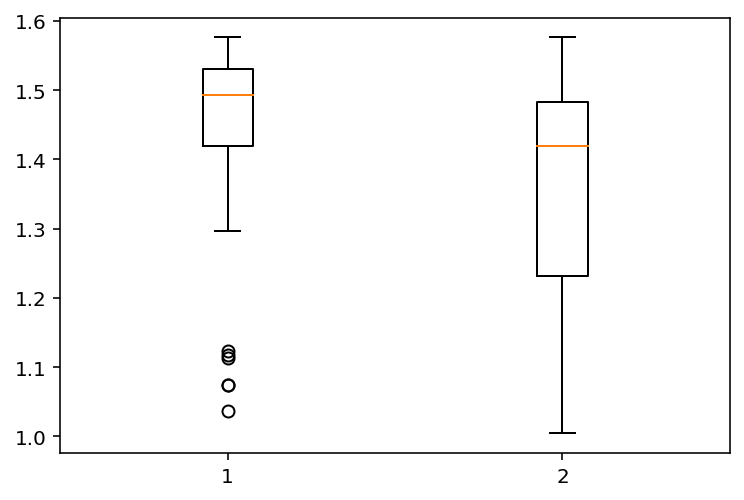

In [273]:
b = np.exp(svi.posterior_predictive['b'].mean(0) * 0.05 * 6.5)
plt.boxplot([b[w], b[~w]])
#plt.

In [274]:
np.quantile(b[w], [0.25,.5,.75])

array([1.41928518, 1.49319875, 1.53026593])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f91ddd3cc90>,
 'caps': [<matplotlib.lines.Line2D at 0x7f91ddd45550>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f91ddd3c8d0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f91ddd45e10>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f91e13e0290>,
 'means': []}

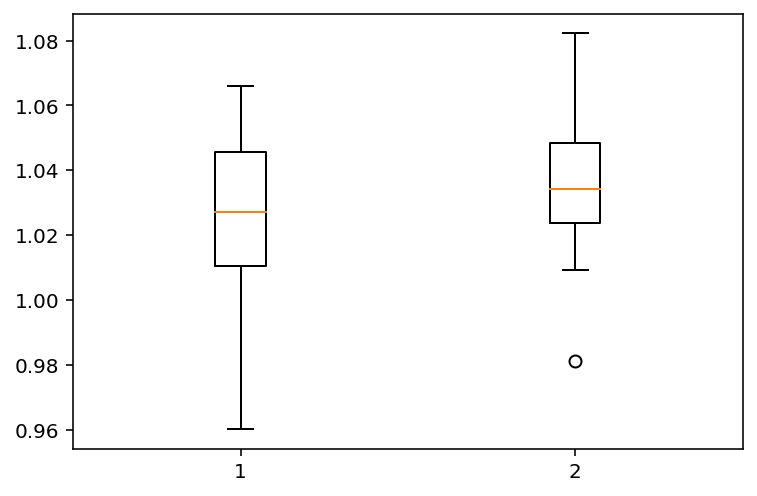

In [275]:
a = np.exp(svi.posterior_predictive['a'].mean(0) * 0.05)
plt.boxplot([a[w], a[~w]])

In [276]:
np.quantile(a[w], [0.25,.5,.75])

array([1.01049614, 1.02707326, 1.04554605])

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


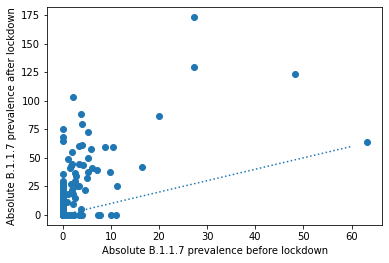

In [410]:
plt.scatter(specimen[S,65] * strain[S,6]/total[S,6], specimen[S,95] * strain[S,10]/total[S,10])
plt.xlabel("Absolute B.1.1.7 prevalence before lockdown")
plt.ylabel("Absolute B.1.1.7 prevalence after lockdown")
plt.plot([0,65],[0,65], ":")

In [358]:
from scipy.stats import spearmanr
spearmanr(x[w], y[w])

SpearmanrResult(correlation=0.31515679442508715, pvalue=0.04474407083070794)

In [466]:
np.corrcoef(x[~v],y[~v])

array([[1.        , 0.13474794],
       [0.13474794, 1.        ]])

In [281]:
s = strain + .5
t = total + 1
x = specimen[S,92] * (1- s[S,10]/t[S,10]) / (specimen[S,65] * (1-s[S,4:6].sum(1)/t[S,4:6].sum(1)) )
y = (specimen[S,92] * s[S,10]/t[S,10]) / (specimen[S,65] * s[S,4:6].sum(1)/t[S,4:6].sum(1) )

In [282]:
v = np.logical_or(np.isnan(x + y) , np.isinf(x + y + 1/y + 1/x))

Text(0.99, 0.01, 'B.1.1.7 controlled\nother escaped')

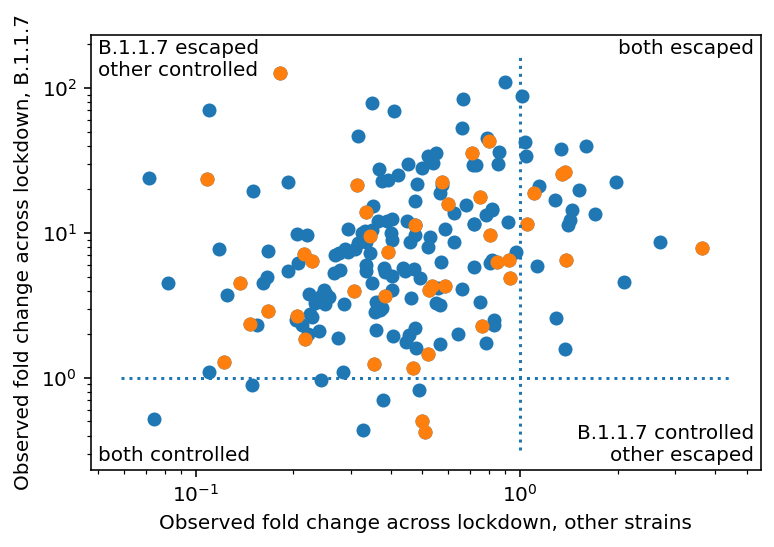

In [322]:
ax = plt.axes()
plt.loglog(x,y, "o")
plt.loglog(x[w],y[w], "o")
plt.xlabel("Observed fold change across lockdown, other strains")
plt.ylabel("Observed fold change across lockdown, B.1.1.7")
#plt.plot([3e-1, 4], [3e-1,4],":", c="C0")
plt.plot(ax.get_xlim(), [1,1],":", c="C0")
plt.plot([1, 1], ax.get_ylim(),":", c="C0")
plt.text(0.01, 0.01, 'both controlled', ha='left',va="bottom", transform=ax.transAxes)
plt.text(0.01, .99, 'B.1.1.7 escaped\nother controlled', ha='left',va="top", transform=ax.transAxes)
plt.text(0.99, 0.99, 'both escaped', ha='right',va="top", transform=ax.transAxes)
plt.text(0.99, 0.01, 'B.1.1.7 controlled\nother escaped', ha='right',va="bottom", transform=ax.transAxes)

In [293]:
ax.get_xlim()

(0.05860270391706279, 4.891027476660178)

In [76]:
import geopandas as gpd

In [82]:
LAD

objectid   pop18    lad19cd               lad19nm  lad19id   utla19cd  \
0           1   93242  E06000001            Hartlepool        0  E06000001   
1           2  140545  E06000002         Middlesbrough        1  E06000002   
2           3  136718  E06000003  Redcar and Cleveland        2  E06000003   
3           4  197213  E06000004      Stockton-on-Tees        3  E06000004   
4           5  106566  E06000005            Darlington        4  E06000005   
..        ...     ...        ...                   ...      ...        ...   
377       378   93049  W06000020               Torfaen      377  W06000020   
378       379   94142  W06000021         Monmouthshire      378  W06000021   
379       380  153302  W06000022               Newport      379  W06000022   
380       381  132447  W06000023                 Powys      380  W06000023   
381       382   60183  W06000024        Merthyr Tydfil      381  W06000024   

                 utla19nm  utla19id   ctry19cd ctry19nm  ctry19id   bng_e  \
0              Hartlepool         0  E92000001  England         0  447160   
1           Middlesbrough         0  E92000001  England         0  451141   
2    Redcar and Cleveland         0  E92000001  England         0  464361   
3        Stockton-on-Tees         0  E92000001  England         0  444940   
4              Darlington         0  E92000001  England         0  428029   
..                    ...       ...        ...      ...       ...     ...   
377               Torfaen         3  W92000004    Wales         3  327459   
378         Monmouthshire         3  W92000004    Wales         3  337812   
379               Newport         3  W92000004    Wales         3  337897   
380                 Powys         3  W92000004    Wales         3  302329   
381        Merthyr Tydfil         3  W92000004    Wales         3  305916   

      bng_n     long        lat    st_areasha     st_lengths  \
0    531474 -1.27018  54.676140  9.371262e+07   71011.933949   
1    516887 -1.21099  54.544670  5.388156e+07   44481.691242   
2    519597 -1.00608  54.567520  2.450695e+08   96703.989701   
3    518183 -1.30664  54.556911  2.049330e+08  123408.985928   
4    515648 -1.56835  54.535339  1.974757e+08  107206.401677   
..      ...      ...        ...           ...            ...   
377  200480 -3.05101  51.698360  1.262399e+08   82544.775967   
378  209231 -2.90280  51.778271  8.502646e+08  224184.496320   
379  187432 -2.89769  51.582310  1.903728e+08  153723.498020   
380  273255 -3.43531  52.348640  5.195312e+09  610145.541416   
381  206424 -3.36425  51.748581  1.119570e+08   66696.929592   

                                              geometry  
0    MULTIPOLYGON (((447213.900 537036.104, 447228....  
1    MULTIPOLYGON (((448609.900 521982.600, 448616....  
2    MULTIPOLYGON (((455932.335 527880.697, 455919....  
3    MULTIPOLYGON (((444157.002 527956.304, 444165....  
4    POLYGON ((423496.602 524724.299, 423497.204 52...  
..                                                 ...  
377  POLYGON ((323898.201 211287.499, 324115.698 21...  
378  MULTIPOLYGON (((327830.799 231005.105, 327840....  
379  MULTIPOLYGON (((342211.900 194845.495, 342221....  
380  POLYGON ((322392.901 334017.198, 322378.002 33...  
381  POLYGON ((303435.502 214925.598, 303431.602 21...  

[382 rows x 18 columns]

In [345]:
mu_1 = np.array(svi.posterior['μ_strain'].mean(0)) #+ 1e-16
mu_0 = np.array(svi.posterior['μ_base'].mean(0)) #+ 1e-16

In [346]:
r_0 = mu_0[:,92]/mu_0[:,65]
r_1 = mu_1[:,92]/mu_1[:,65]

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


{'whiskers': [<matplotlib.lines.Line2D at 0x7f927e579710>,
 'caps': [<matplotlib.lines.Line2D at 0x7f92810cfed0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f91e86b0dd0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f91e8b64d10>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f9274839510>,
 'means': []}

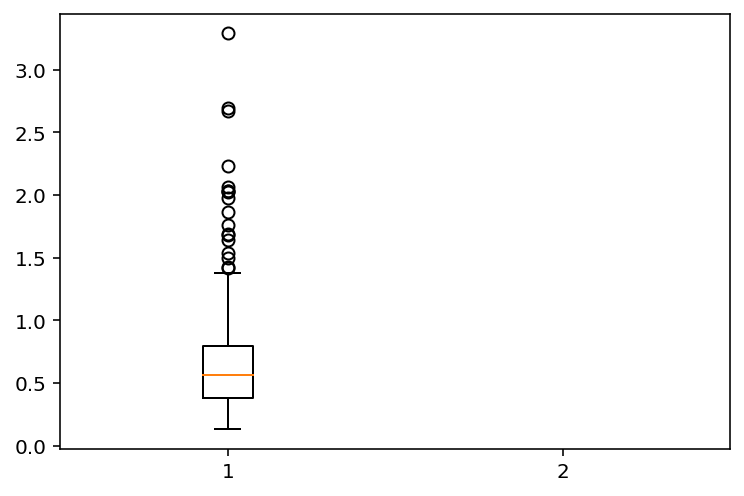

In [347]:
plt.boxplot([r_0,r_1])

In [348]:
r_1.shape

(382,)

In [349]:
np.isnan(r_1).sum()

188

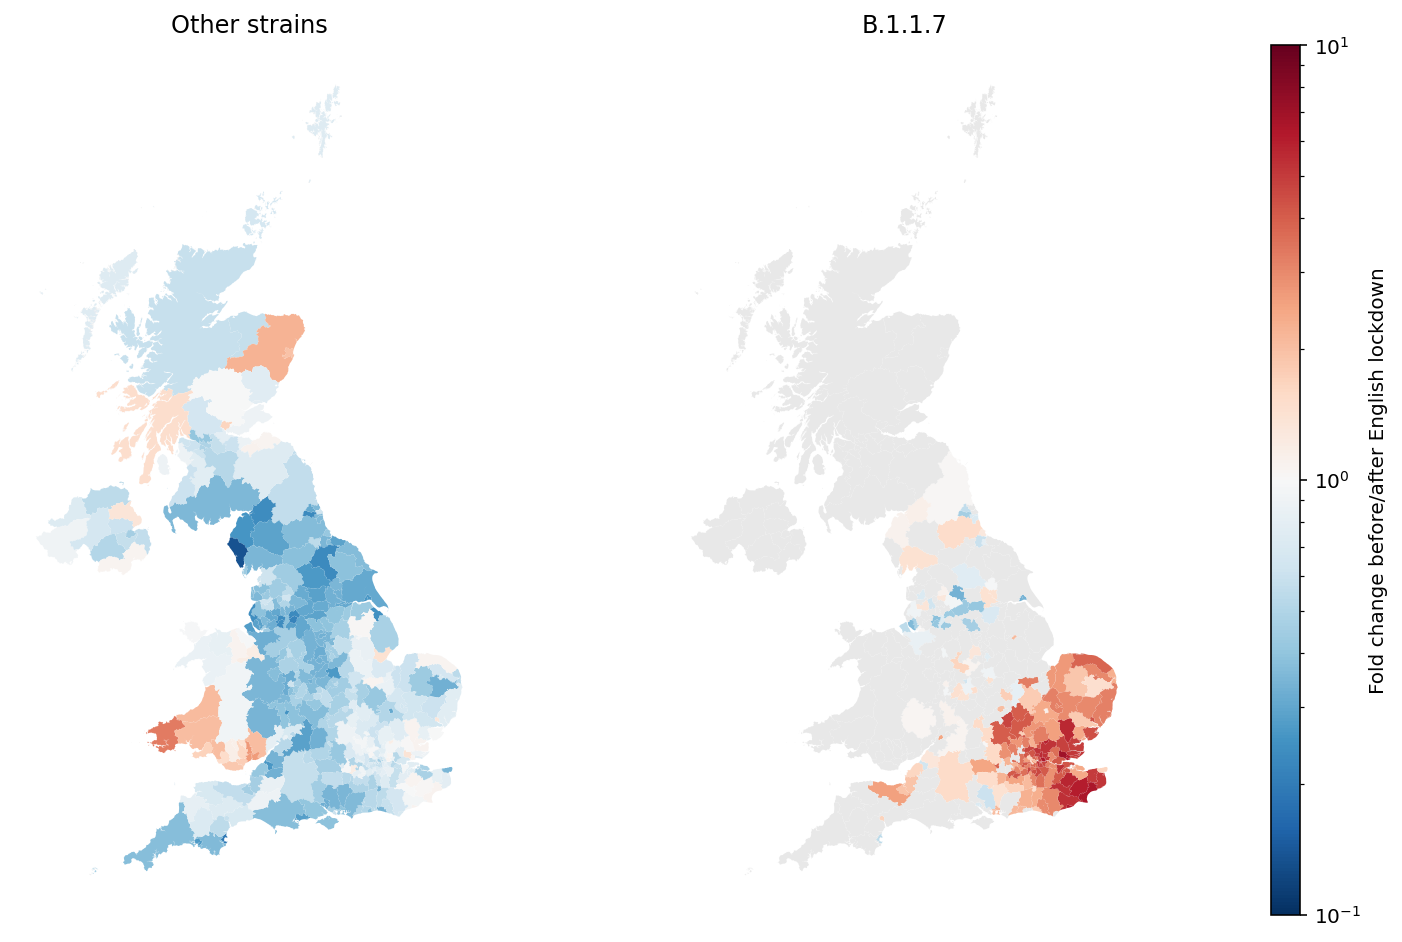

In [359]:
from matplotlib import cm, colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format='retina'
g = LAD.copy()
g['r_0']= r_0
g['r_1'] = r_1
fig, ax = plt.subplots(1, 3, figsize=(12, 8),  gridspec_kw={'width_ratios': [10, 10, 0.5]}, facecolor="white")
#fig.figsize=(20,10)
#divider = make_axes_locatable(ax[1])
#cax = divider.append_axes("right", size="5%", pad=0.1)
g.plot(column='r_0', ax=ax[0], cmap="RdBu_r", norm=colors.LogNorm(vmin=0.1, vmax=10))
ax[0].set_title("Other strains")
ax[0].set_axis_off()
g.plot(column='r_1', ax=ax[1], cmap="RdBu_r", norm=colors.LogNorm(vmin=0.1, vmax=10), legend=True, cax=ax[2], 
       legend_kwds={'label': "Fold change before/after English lockdown"},
      missing_kwds={ "color": "#E8E8E8", "label": "Missing values"})
ax[1].set_title("B.1.1.7")
ax[1].set_axis_off()
#norm = colors.Normalize(vmin=-1, vmax=1)
#fig.colorbar(cm.ScalarMappable(norm=norm, cmap="RdBu"),
#             cax=ax[2], orientation='vertical', label='Fold change pre/post lockdown')


In [145]:
g

objectid    lad19cd               lad19nm        lad19nmw   bng_e  \
0           1  E06000001            Hartlepool                  447160   
1           2  E06000002         Middlesbrough                  451141   
2           3  E06000003  Redcar and Cleveland                  464361   
3           4  E06000004      Stockton-on-Tees                  444940   
4           5  E06000005            Darlington                  428029   
..        ...        ...                   ...             ...     ...   
377       378  W06000020               Torfaen         Torfaen  327459   
378       379  W06000021         Monmouthshire       Sir Fynwy  337812   
379       380  W06000022               Newport       Casnewydd  337897   
380       381  W06000023                 Powys           Powys  302329   
381       382  W06000024        Merthyr Tydfil  Merthyr Tudful  305916   

      bng_n      long        lat  st_areashape  st_lengthshape  \
0    531474 -1.270189  54.676140  9.377035e+07    68481.646732   
1    516887 -1.210998  54.544678  5.385812e+07    42570.873543   
2    519597 -1.006086  54.567524  2.451404e+08    94686.620905   
3    518183 -1.306645  54.556911  2.049037e+08   118320.900278   
4    515648 -1.568356  54.535343  1.974858e+08   105777.871675   
..      ...       ...        ...           ...             ...   
377  200480 -3.051019  51.698360  1.262231e+08    78980.290566   
378  209231 -2.902806  51.778278  8.502516e+08   218427.823924   
379  187432 -2.897690  51.582310  1.903740e+08   148812.809039   
380  273255 -3.435318  52.348648  5.195419e+09   590016.735868   
381  206424 -3.364258  51.748589  1.119303e+08    65314.320984   

                                              geometry  
0    POLYGON ((-1.27025 54.72717, -1.27251 54.72541...  
1    MULTIPOLYGON (((-1.23002 54.58412, -1.23742 54...  
2    MULTIPOLYGON (((-1.13483 54.63859, -1.13613 54...  
3    MULTIPOLYGON (((-1.31776 54.64525, -1.31871 54...  
4    POLYGON ((-1.63800 54.61720, -1.64078 54.61740...  
..                                                 ...  
377  POLYGON ((-3.10597 51.79548, -3.10844 51.79623...  
378  MULTIPOLYGON (((-3.05215 51.97295, -3.05696 51...  
379  MULTIPOLYGON (((-2.83440 51.64824, -2.83682 51...  
380  MULTIPOLYGON (((-3.90622 52.56080, -3.90617 52...  
381  POLYGON ((-3.40510 51.81742, -3.40481 51.81764...  

[382 rows x 11 columns]